# House Prices

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import sklearn
from sklearn.impute import KNNImputer
import time

from feature_engine.encoding import OrdinalEncoder
from feature_engine.encoding import OneHotEncoder as OneHotEncoder
from feature_engine.encoding import MeanEncoder
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from feature_engine.selection import DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.multioutput import MultiOutputRegressor

In [2]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

C:\Python3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# import sys
# !{sys.executable} -m pip install mlxtend

## Load dataset

In [4]:
# !ln -s "/content/drive/MyDrive/AICamp/Feature engineering project"

In [5]:
# !ls "Feature engineering project"

In [6]:
# %cd "Feature engineering project"

##### Unzip dataset

In [7]:
#!unzip "house-prices-advanced-regression-techniques.zip"

#### Load dataset

In [8]:
df_train = pd.read_csv("train.csv", index_col="Id")
df_test = pd.read_csv("test.csv", index_col="Id")


In [9]:
df_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_test.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Util functions


In [11]:
def check_missing(col_name):
    n_missing = df_train[col_name].isna().sum()
    total = len(df_train[col_name])
    rate =  round((n_missing*1.0)/total, 4)
    print(f"The column {col_name} has {n_missing} missing values in total {total} ({rate})")

In [12]:
def plot_distributions(serie, dropna=True):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    serie = serie.dropna()
    sns.boxplot(serie, ax=ax[0])


    #sns.displot(np.array(df_train['LotFrontage'].dropna()))

    sns.distplot(serie, ax=ax[1], fit=stats.norm, fit_kws={"color":"red"})
    (mu, sigma) = stats.norm.fit(serie)
    plt.legend(['Normal Distribution \n ($\mu=$ {:.2f} and  $\sigma=$ {:.2f} )'.format(mu, sigma)],
                 loc='best', fancybox=True)
    plt.show()

In [13]:
# The function to check Rare labels
def check_rare_labels(df, cols, rate=0.05):
    rare_cols = {}
    for col in cols:
        value_rate = df[col].value_counts(ascending=True).divide(len(df_train[col]))
        rare_cols[col] = value_rate[value_rate < 0.05]
        
    return rare_cols
            

In [14]:
def check_cate_train_vs_test(df_train, df_test, cols):
    mismatch_cols = {}
    for col in cols:
        print(set(df_test[col].unique()).difference(set(df_train[col].unique())))

In [15]:
def make_submission(model, X_test, X_test_id, file_name):    
    y_pred = model.predict(X_test)
    sub = pd.DataFrame()
    sub['Id'] = X_test_id
    sub['SalePrice'] = y_pred
    sub.to_csv(file_name,index=False)

## I. Feature engineering

### EDA 


#### The shape of dataset

In [16]:
train_shape = df_train.shape
test_shape = df_test.shape

print(f"The train set has {train_shape[0]} rows and {train_shape[1]} columns (including target)!")
print(f"The test set has {test_shape[0]} rows and {test_shape[1]} columns!")

The train set has 1460 rows and 80 columns (including target)!
The test set has 1459 rows and 79 columns!


In [17]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Check distribution of SalePrice

In [18]:
df_test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,52.619342,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,176.753926,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,0.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


Splitting features and targets

In [19]:
X_train = df_train.drop(columns='SalePrice')
y_train = df_train['SalePrice']
X_test = df_test.copy()


print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print(f"X_test shape is: {X_test.shape}")

X_train shape is: (1460, 79)
y_train shape is: (1460,)
X_test shape is: (1459, 79)


#### Data types in Train/Test

In [20]:
train_dtypes = X_train.dtypes
test_dtypes = X_test.dtypes

print(f"There are {len(train_dtypes.unique())} data types: {train_dtypes.unique()} in X_train.")
print(f"There are {len(test_dtypes.unique())} data types: {test_dtypes.unique()} in X_test.")
#print(f"Data type of column MSSubClass is {data_types['MSSubClass']}")

There are 3 data types: [dtype('int64') dtype('O') dtype('float64')] in X_train.
There are 3 data types: [dtype('int64') dtype('O') dtype('float64')] in X_test.


In [21]:
missmatch_dtypes = train_dtypes.compare(test_dtypes)
missmatch_dtypes

,self,other
BsmtFinSF1,int64,float64
BsmtFinSF2,int64,float64
BsmtUnfSF,int64,float64
TotalBsmtSF,int64,float64
BsmtFullBath,int64,float64
BsmtHalfBath,int64,float64
GarageCars,int64,float64
GarageArea,int64,float64


Get numerical/categorical columns


In [22]:
train_dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [23]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
print(f"There are {len(numerical_cols)} numerical columns")
numerical_cols[:10]

There are 36 numerical columns


Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2'],
      dtype='object')

In [24]:
categorical_cols = X_train.select_dtypes(include=['O']).columns
print(f"There are {len(categorical_cols)} categorical columns")
categorical_cols[:10]

There are 43 categorical columns


Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1'],
      dtype='object')

#### Matching data type for train/test
Change data type of the columns in train set which mismatch with test set in order to match test set.

Change data type of columns in train set missmatch_data_type_col to float64

In [25]:
#new_dtypes = {}
for col in missmatch_dtypes.index:
    #cast mismatched dtype from int64 to float64
    X_train[col] = X_train[col].astype('float64')
    #df_train[col] = df_train[col].astype(missmatch_dtypes.loc['BsmtFinSF1', 'other'])
    print(X_train[col].dtypes)

float64
float64
float64
float64
float64
float64
float64
float64


In [26]:
X_train.dtypes.compare(X_test.dtypes)

,self,other


The data types are the same in train and test set

#### Checking missing values

In [27]:
def check_missing_values(df):
    missing_percent = df.isna().sum().sort_values(ascending=False) / len(df)
    return missing_percent

In [28]:
# Checking missing values on train set
na_train = check_missing_values(X_train)
na_train[:10]

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
Fence          0.807534
FireplaceQu    0.472603
LotFrontage    0.177397
GarageType     0.055479
GarageYrBlt    0.055479
GarageQual     0.055479
GarageCond     0.055479
dtype: float64

<AxesSubplot:>

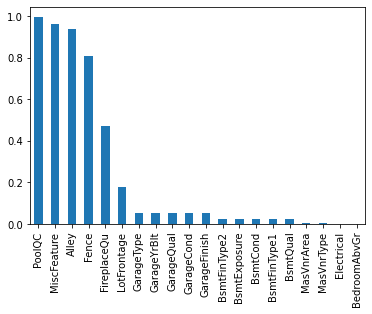

In [29]:
na_train[:20].plot(kind='bar')

In [30]:
# Checking missing values on train set
na_test = check_missing_values(X_test)
na_test[:10]


PoolQC          0.997944
MiscFeature     0.965045
Alley           0.926662
Fence           0.801234
FireplaceQu     0.500343
LotFrontage     0.155586
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageQual      0.053461
GarageCond      0.053461
dtype: float64

<AxesSubplot:>

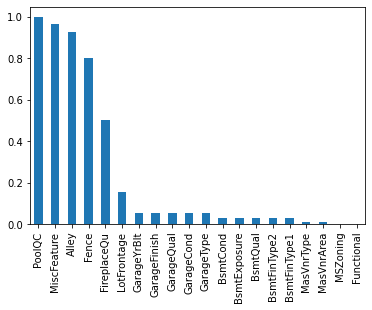

In [31]:
na_test[:20].plot(kind='bar')

Check the difference of missing features in X_train and X_test

In [32]:
set(na_train[na_train>0].index).difference(set(na_test[na_test>0].index))

{'Electrical'}

In [33]:
set(na_test[na_test>0].index).difference(set(na_train[na_train>0].index))

{'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'Exterior1st',
 'Exterior2nd',
 'Functional',
 'GarageArea',
 'GarageCars',
 'KitchenQual',
 'MSZoning',
 'SaleType',
 'TotalBsmtSF',
 'Utilities'}

Electrical is missing (1 record) in X_train but not missing in X_test

In [34]:
missing_cols = na_train.index

#### Distribution of target

In [35]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:title={'center':'Distribution of target'}, ylabel='Frequency'>

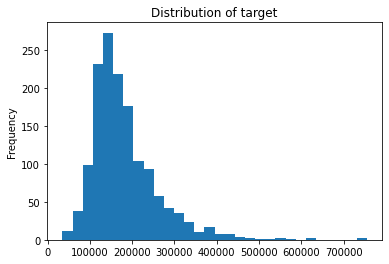

In [36]:
df_train['SalePrice'].plot(kind='hist', bins=30, title='Distribution of target')

C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Normal Dist'}, xlabel='SalePrice'>

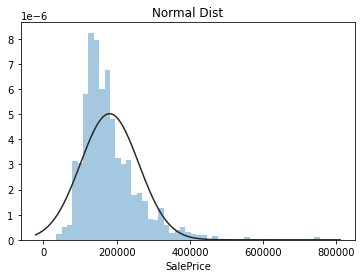

In [37]:
plt.figure(2)
plt.title('Normal Dist')
sns.distplot(y_train, kde=False, fit=stats.norm)

#### Correlation matrix

In [38]:
numerical_cols_and_target = list(numerical_cols)
numerical_cols_and_target.append('SalePrice')

corr_matrix = df_train[numerical_cols_and_target].corr().round(2)

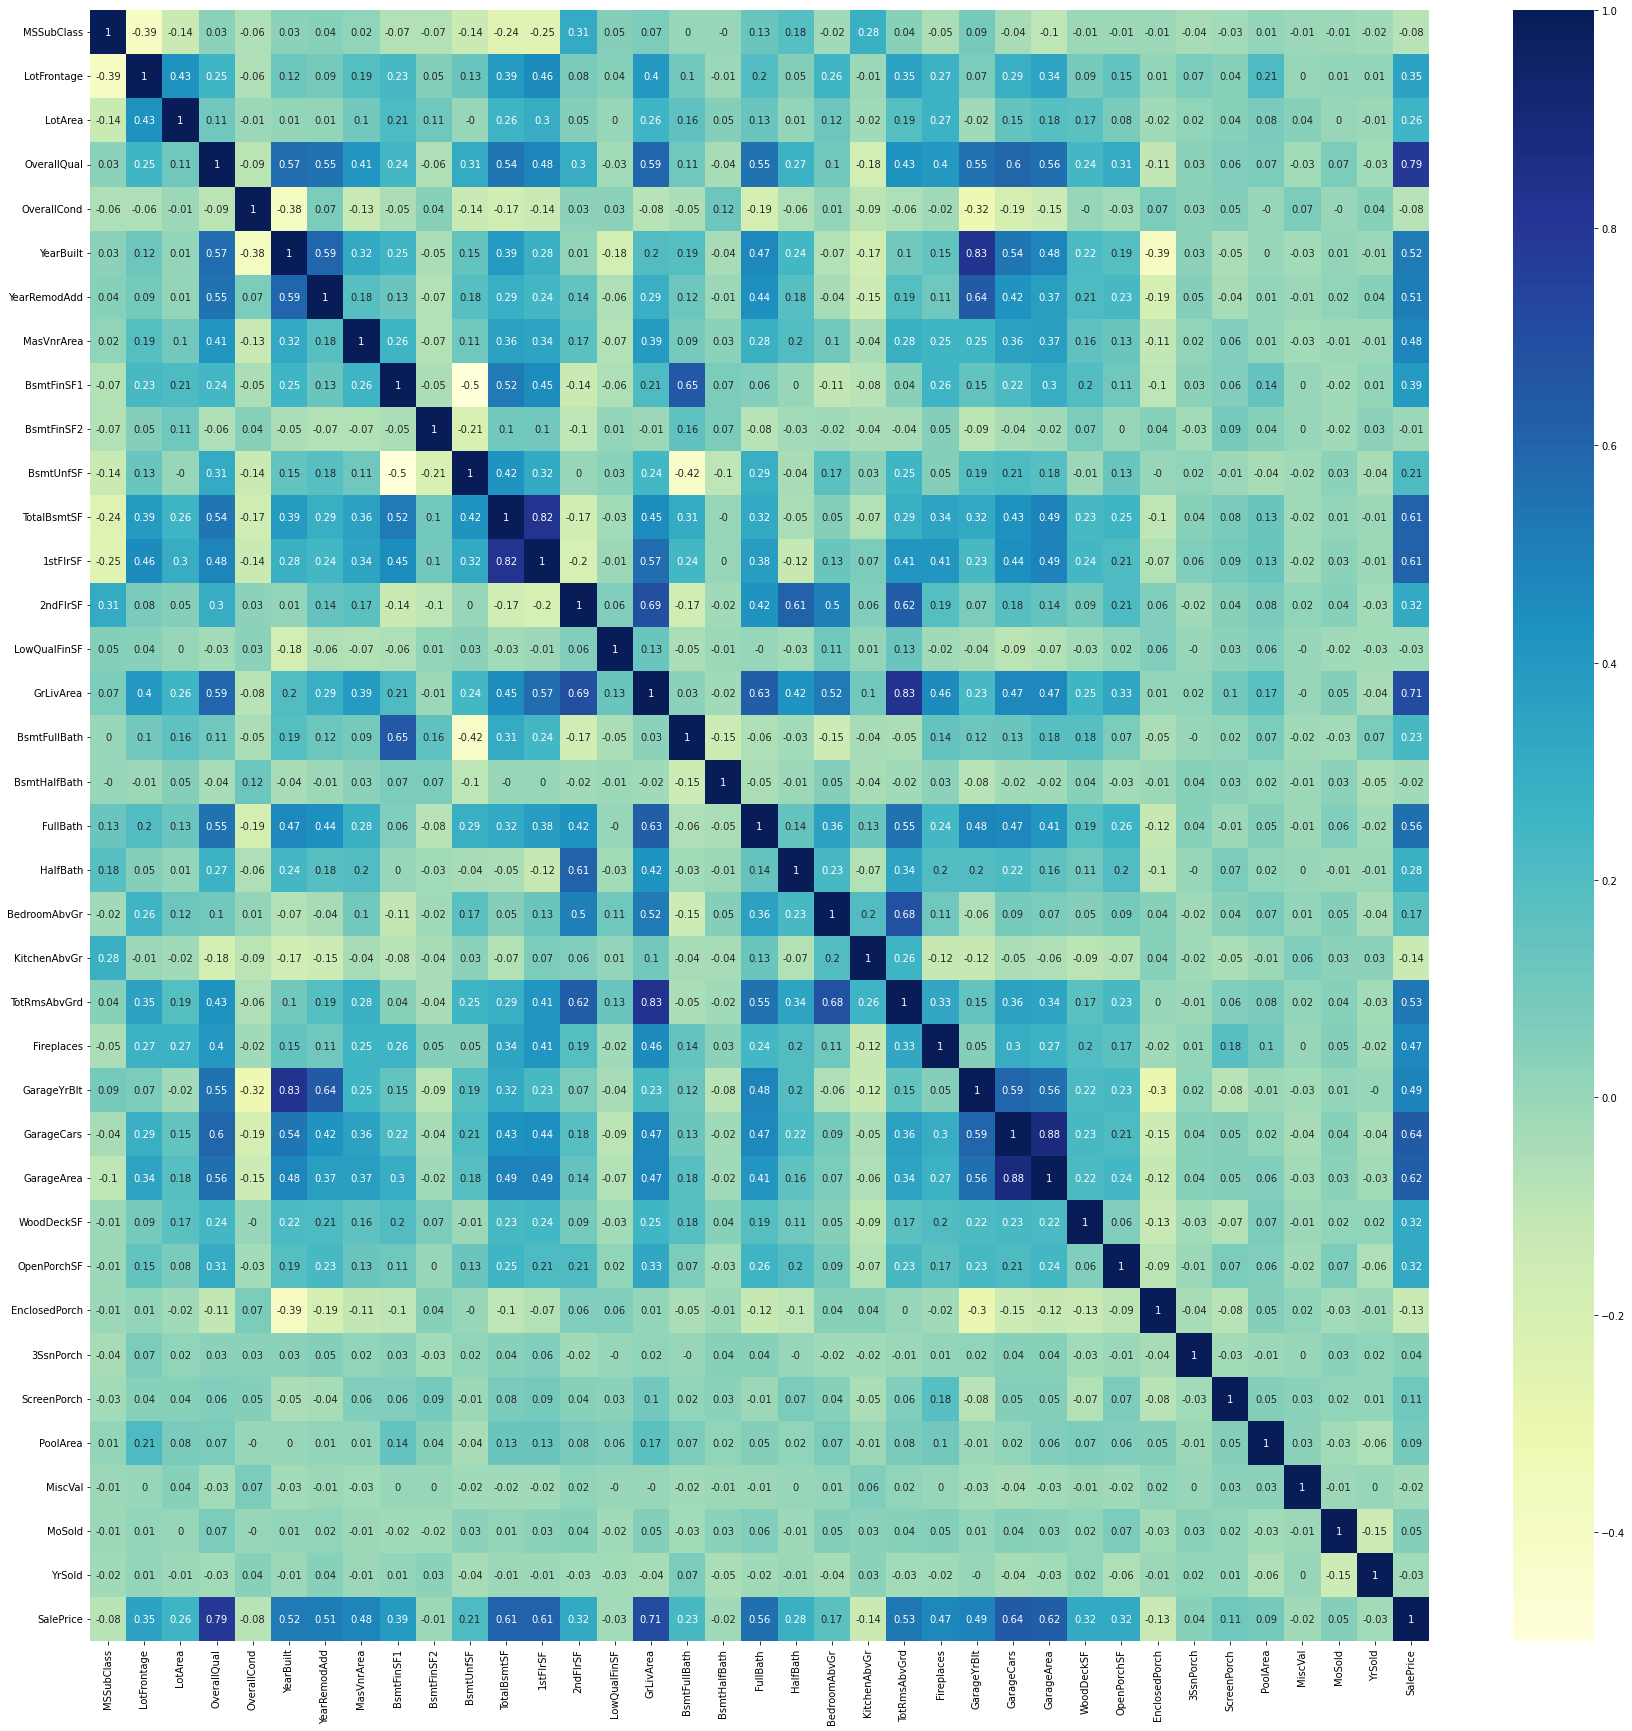

In [39]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corr_matrix, cmap="YlGnBu", annot=True, ax=ax)
plt.show()

### Missing data

#### Missing cols > 20%

Get columns with missing percentage greater than 40%

In [40]:
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

In [41]:
cols_with_gt_40_missing = set(na_test[na_test > 0.4].index).union(set(na_train[na_train > 0.4].index))
cols_with_gt_40_missing

{'Alley', 'Fence', 'FireplaceQu', 'MiscFeature', 'PoolQC'}

In [42]:
ignored_cols = []

##### Alley column

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

In [43]:
print(f"No of missing values of Alley column: {X_train_imputed['Alley'].isna().sum()} / {len(X_train_imputed)}  ({round(na_train['Alley'], 2)})")

No of missing values of Alley column: 1369 / 1460  (0.94)


**==>This is not missing, NA value means the houses have no alley access, we keep this feature**

In [44]:
X_train_imputed['Alley'].fillna('NA', inplace=True)
X_train_imputed['Alley'].isnull().sum()

0

In [45]:
X_test_imputed['Alley'].fillna('NA', inplace=True)
X_test_imputed['Alley'].isnull().sum()

0

##### Fence column
Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

In [46]:
print(f"No of missing values of Fence column: {X_train_imputed['Fence'].isna().sum()} / {len(X_train_imputed)}  ({round(na_train['Fence'], 2)})")

No of missing values of Fence column: 1179 / 1460  (0.81)


**==>This is same as Alley, NA value means the houses have no Fence, we keep this feature**

In [47]:
X_train_imputed['Fence'].fillna('NA', inplace=True)
X_train_imputed['Fence'].isnull().sum()

0

In [48]:
X_test_imputed['Fence'].fillna('NA', inplace=True)
X_test_imputed['Fence'].isnull().sum()

0

##### FireplaceQu
FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [49]:
print(f"No of missing values of FireplaceQu column: "
      f"{X_train_imputed['FireplaceQu'].isna().sum()} / {len(X_train_imputed)} ({round(na_train['FireplaceQu'], 2)})")

No of missing values of FireplaceQu column: 690 / 1460 (0.47)


**==>This is same as Alley, NA value means the houses have no Fireplace, we keep this feature**

In [50]:
X_train_imputed['FireplaceQu'].fillna('NA', inplace=True)
X_train_imputed['FireplaceQu'].isnull().sum()

0

In [51]:
X_test_imputed['FireplaceQu'].fillna('NA', inplace=True)
X_test_imputed['FireplaceQu'].isnull().sum()

0

##### PoolQC
PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

In [52]:
print(f"No of missing values of PoolQC column: "
      f"{X_train_imputed['PoolQC'].isna().sum()} / {len(X_train_imputed)} ({round(na_train['PoolQC'], 2)})")

No of missing values of PoolQC column: 1453 / 1460 (1.0)


**==>This is same as Alley, NA value means the houses have no Pool, we keep this feature**

In [53]:
X_train_imputed['PoolQC'].fillna('NA', inplace=True)
X_train_imputed['PoolQC'].isnull().sum()

0

In [54]:
X_test_imputed['PoolQC'].fillna('NA', inplace=True)
X_test_imputed['PoolQC'].isnull().sum()

0

##### MiscFeature
MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [55]:
print(f"No of missing values of MiscFeature column: "
      f"{X_train_imputed['MiscFeature'].isna().sum()} / {len(X_train_imputed)} ({round(na_train['MiscFeature'], 2)})")

No of missing values of MiscFeature column: 1406 / 1460 (0.96)


**==>This is not the same as Alley, NA value means None, we can remove this feature**

In [56]:
X_train_imputed.drop(columns='MiscFeature', inplace=True)
assert 'MiscFeature' not in X_train_imputed.columns, "MiscFeature column is removed, please check!"

In [57]:
X_test_imputed.drop(columns='MiscFeature', inplace=True)
assert 'MiscFeature' not in X_train_imputed.columns, "MiscFeature column is removed, please check!"

In [58]:
ignored_cols.append('MiscFeature')
ignored_cols

['MiscFeature']

In [59]:
categorical_cols = categorical_cols.drop('MiscFeature')

#### Missing cols 0-20%

Get columns with missing percentage greater than 0% and less than 40%

In [60]:
#get columns with missing percentage greater than 0% and less than 40%
missing_cols_lt_40 = set(na_train[na_train > 0].index) - cols_with_gt_40_missing
print(f"There are {len(missing_cols_lt_40)} columns with missing percentage in range (0-0.4)")

There are 14 columns with missing percentage in range (0-0.4)


In [61]:
na_train[:20]

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageType      0.055479
GarageYrBlt     0.055479
GarageQual      0.055479
GarageCond      0.055479
GarageFinish    0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtCond        0.025342
BsmtFinType1    0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
BedroomAbvGr    0.000000
dtype: float64

Missing columns are numerical

In [62]:
numerical_missing_cols = set(missing_cols_lt_40).intersection(set(numerical_cols))
numerical_missing_cols

{'GarageYrBlt', 'LotFrontage', 'MasVnrArea'}

Missing columns are categorical

In [63]:
categorical_missing_cols = set(missing_cols_lt_40).intersection(set(categorical_cols))
categorical_missing_cols

{'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'Electrical',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'MasVnrType'}

##### Features relevant Garage


GarageYrBlt: Year garage was built
		
GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage
		
GarageCars: Size of garage in car capacity

GarageArea: Size of garage in square feet

GarageQual: Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage
		
GarageCond: Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage

['GarageYrBlt', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']

In [64]:
X_train_imputed['GarageYrBlt'].unique()

array([2003., 1976., 2001., 1998., 2000., 1993., 2004., 1973., 1931.,
       1939., 1965., 2005., 1962., 2006., 1960., 1991., 1970., 1967.,
       1958., 1930., 2002., 1968., 2007., 2008., 1957., 1920., 1966.,
       1959., 1995., 1954., 1953.,   nan, 1983., 1977., 1997., 1985.,
       1963., 1981., 1964., 1999., 1935., 1990., 1945., 1987., 1989.,
       1915., 1956., 1948., 1974., 2009., 1950., 1961., 1921., 1900.,
       1979., 1951., 1969., 1936., 1975., 1971., 1923., 1984., 1926.,
       1955., 1986., 1988., 1916., 1932., 1972., 1918., 1980., 1924.,
       1996., 1940., 1949., 1994., 1910., 1978., 1982., 1992., 1925.,
       1941., 2010., 1927., 1947., 1937., 1942., 1938., 1952., 1928.,
       1922., 1934., 1906., 1914., 1946., 1908., 1929., 1933.])

In [65]:
X_train_imputed['GarageYrBlt'].fillna(0, inplace=True)

In [66]:
X_test_imputed['GarageYrBlt'].fillna(0, inplace=True)

In [67]:
garage_features = ['GarageYrBlt', 'GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']

In [68]:
print(f"The columns GarageFinish has {X_train_imputed['GarageFinish'].isna().sum()} missing values in total {len(X_train_imputed['GarageFinish'])}")

The columns GarageFinish has 81 missing values in total 1460


In [69]:
# Check features of garage with houses don't have garage
houses_no_garage = X_train_imputed[X_train_imputed['GarageFinish'].isna()][garage_features]
houses_no_garage.head()

,GarageYrBlt,GarageQual,GarageCond,GarageFinish,GarageType
Id,,,,,
40,0.0,NaN,NaN,NaN,NaN
49,0.0,NaN,NaN,NaN,NaN
79,0.0,NaN,NaN,NaN,NaN
89,0.0,NaN,NaN,NaN,NaN
90,0.0,NaN,NaN,NaN,NaN


In [70]:
#Count non-NA values in garage features on houses that have no garage
houses_no_garage.notna().sum()

GarageYrBlt     81
GarageQual       0
GarageCond       0
GarageFinish     0
GarageType       0
dtype: int64

In [71]:
X_train_imputed['GarageFinish'].isna().sum()

81

**==>Conclusion: Houses have no garage (GarageFinish=NA), its garage features also missing values**

It is a type of missing data - structural missing data as a special case of data that is missing not at random

**Impute categorical garage features**

In [72]:
for col in ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']:
    X_train_imputed[col].fillna('NA', inplace=True)
X_train_imputed[['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']].isna().sum()

GarageQual      0
GarageCond      0
GarageFinish    0
GarageType      0
dtype: int64

In [73]:
for col in ['GarageQual', 'GarageCond', 'GarageFinish', 'GarageType']:
    X_test_imputed[col].fillna('NA', inplace=True)

**Impute numerical garage features**

In [74]:
for col in ['GarageCars', 'GarageArea']:
    X_train_imputed[col].fillna(0, inplace=True)
X_train_imputed[['GarageCars', 'GarageArea']].isna().sum()

GarageCars    0
GarageArea    0
dtype: int64

In [75]:
for col in ['GarageCars', 'GarageArea']:
    X_test_imputed[col].fillna(0, inplace=True)

##### Features relevant Basement



BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement
       
	
BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement
	
BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
		
BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement
       
BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area


In [76]:
bmstFeatures = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

In [77]:
X_train_imputed[bmstFeatures].isna().sum()

BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinSF1       0
BsmtFinType2    38
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
dtype: int64

**=> NA is no basement (a category), we dont apply any imputation for basement features**

In [78]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1']:
    X_train_imputed[col].fillna('NA', inplace=True)
    print(f"{X_train_imputed[col].isna().sum()} missing in {col}")

0 missing in BsmtQual
0 missing in BsmtCond
0 missing in BsmtExposure
0 missing in BsmtFinType1


In [79]:
for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1']:
    X_test_imputed[col].fillna('NA', inplace=True)

In [80]:
for col in ['BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    X_train_imputed[col].fillna(0, inplace=True)
    print(f"{X_train_imputed[col].isna().sum()} missing in {col}")

0 missing in BsmtFinSF1
0 missing in BsmtFinType2
0 missing in BsmtFinSF2
0 missing in BsmtUnfSF
0 missing in TotalBsmtSF


In [81]:
for col in ['BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']:
    X_test_imputed[col].fillna(0, inplace=True)

##### Other columns

In [82]:
missing_others = missing_cols_lt_40 - set(bmstFeatures) - set(garage_features)
missing_others

{'Electrical', 'LotFrontage', 'MasVnrArea', 'MasVnrType'}

##### Electrical

In [83]:
check_missing('Electrical')

The column Electrical has 1 missing values in total 1460 (0.0007)


In [84]:
print(f"Number of missing values on Electrical column in test set: {X_test['Electrical'].isna().sum()}")

Number of missing values on Electrical column in test set: 0


**=> Remove the row which missing Electrical in train set**

The missing Electrical only happen on train set

In [85]:
X_train_imputed_1 = X_train_imputed.copy()
y_train_1 = y_train.copy()

In [86]:
idx_dropped_row = X_train_imputed[X_train_imputed['Electrical'].isna()].index
idx_dropped_row

Int64Index([1380], dtype='int64', name='Id')

In [87]:
df_train_bk = df_train.copy()
df_train[df_train['Electrical'].isna()]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [88]:
df_train.drop(idx_dropped_row, inplace=True)

In [89]:
#org_df_train = df_train.copy()
X_train_imputed.drop(idx_dropped_row, inplace=True)
y_train.drop(idx_dropped_row, inplace=True)

X_train_imputed.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)

In [90]:
print(f"The shape of X_train_imputed is {X_train_imputed.shape}")
print(f"The shape of y_train is {y_train.shape}")

The shape of X_train_imputed is (1459, 78)
The shape of y_train is (1459,)


In [91]:
X_train_imputed['Electrical'].isna().sum()

0

##### MasVnrType
MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

In [92]:
check_missing('MasVnrType')

The column MasVnrType has 8 missing values in total 1459 (0.0055)


In [93]:
X_train_imputed['MasVnrType'].value_counts(ascending=False, dropna=False)

None       863
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

Imputation method for MasVnrType colunm is Most Frequency (NaN same as None)

In [94]:
X_train_imputed['MasVnrType'] = X_train_imputed['MasVnrType'].fillna('None')
X_train_imputed['MasVnrType'].value_counts(ascending=False, dropna=False)

None       871
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [95]:
X_test_imputed['MasVnrType'] = X_test_imputed['MasVnrType'].fillna('None')
X_test_imputed['MasVnrType'].value_counts(ascending=False, dropna=False)

None       894
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

Check MasVnrArea and MasVnrType if one of them is None

In [96]:
X_train_imputed[(X_train_imputed['MasVnrArea'].isna()) | (X_train_imputed['MasVnrType'].isna())][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
234,NaN,None
529,NaN,None
650,NaN,None
936,NaN,None
973,NaN,None
977,NaN,None
1243,NaN,None
1278,NaN,None


Check MasVnrArea where MasVnrType is None

In [97]:
X_train_imputed[X_train_imputed['MasVnrType'] == 'None']['MasVnrArea'].value_counts(ascending=False)

0.0      858
1.0        2
288.0      1
344.0      1
312.0      1
Name: MasVnrArea, dtype: int64

##### MasVnrArea
MasVnrArea: Masonry veneer area in square feet

In [98]:
check_missing('MasVnrArea')

The column MasVnrArea has 8 missing values in total 1459 (0.0055)


In [99]:
print(f"Number of missing values on MasVnrArea column in test set: {X_test['MasVnrArea'].isna().sum()}")

Number of missing values on MasVnrArea column in test set: 15


In [100]:
X_train_imputed['MasVnrArea'].value_counts(ascending=False)

0.0      860
180.0      8
72.0       8
108.0      8
120.0      7
        ... 
562.0      1
89.0       1
921.0      1
762.0      1
119.0      1
Name: MasVnrArea, Length: 327, dtype: int64

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


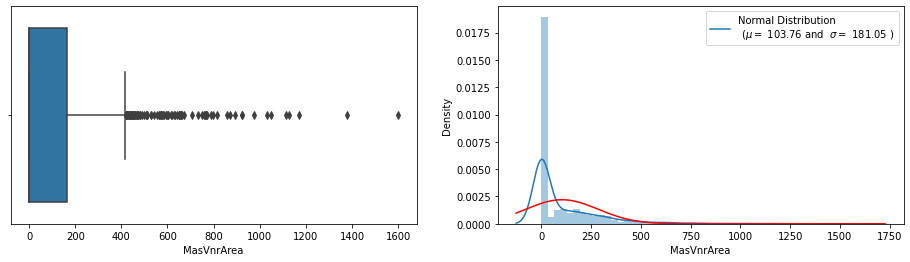

In [101]:
plot_distributions(X_train_imputed['MasVnrArea'])


**Impute NA value in MasVnrArea = 0 because MasVnrType is None**

In [102]:
X_train_imputed['MasVnrArea'] = X_train_imputed['MasVnrArea'].fillna(0)
X_train_imputed['MasVnrArea'].isna().sum()

0

In [103]:
X_test_imputed['MasVnrArea'] = X_test_imputed['MasVnrArea'].fillna(0)
X_test_imputed['MasVnrArea'].isna().sum()

0

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


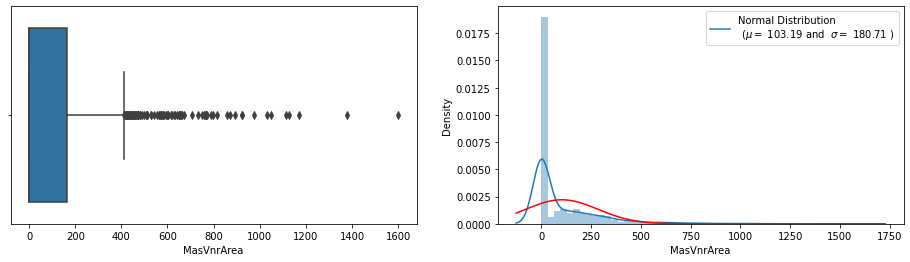

In [104]:
plot_distributions(X_train_imputed['MasVnrArea'])

##### LotFrontage
LotFrontage: Linear feet of street connected to property

In [105]:
X_train_imputed['LotFrontage'].head()

0    65.0
1    80.0
2    68.0
3    60.0
4    84.0
Name: LotFrontage, dtype: float64

In [106]:
check_missing('LotFrontage')

The column LotFrontage has 259 missing values in total 1459 (0.1775)


In [107]:
X_train_imputed['LotFrontage'].describe()

count    1200.000000
mean       70.047500
std        24.294727
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


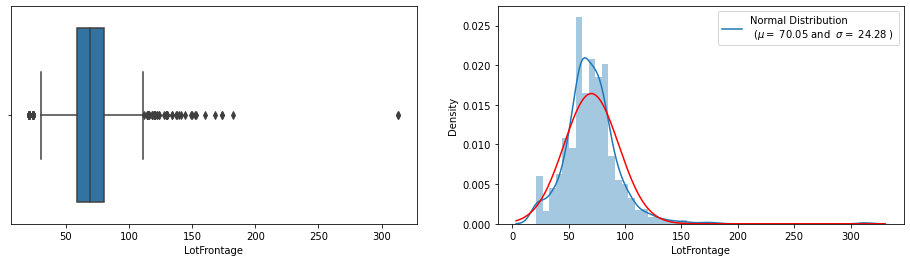

In [108]:
plot_distributions(df_train['LotFrontage'])

LotFrontage after removing NA

**The LotFrontage**


Using KNN imputer to impute missing value in LotFrontage

In [109]:
corr = corr_matrix.loc['LotFrontage'].sort_values()
high_corr = pd.concat([corr[(corr < -0.2)], corr[(corr > 0.2)]])
high_corr

MSSubClass     -0.39
PoolArea        0.21
BsmtFinSF1      0.23
OverallQual     0.25
BedroomAbvGr    0.26
Fireplaces      0.27
GarageCars      0.29
GarageArea      0.34
TotRmsAbvGrd    0.35
SalePrice       0.35
TotalBsmtSF     0.39
GrLivArea       0.40
LotArea         0.43
1stFlrSF        0.46
LotFrontage     1.00
Name: LotFrontage, dtype: float64

In [110]:
cols_to_use = high_corr.index
cols_to_use

Index(['MSSubClass', 'PoolArea', 'BsmtFinSF1', 'OverallQual', 'BedroomAbvGr',
       'Fireplaces', 'GarageCars', 'GarageArea', 'TotRmsAbvGrd', 'SalePrice',
       'TotalBsmtSF', 'GrLivArea', 'LotArea', '1stFlrSF', 'LotFrontage'],
      dtype='object')

In [111]:
X_train_lf = X_train_imputed[cols_to_use.drop('SalePrice')]
X_train_lf.head()

,MSSubClass,PoolArea,BsmtFinSF1,OverallQual,BedroomAbvGr,Fireplaces,GarageCars,GarageArea,TotRmsAbvGrd,TotalBsmtSF,GrLivArea,LotArea,1stFlrSF,LotFrontage
0,60,0,706.0,7,3,0,2.0,548.0,8,856.0,1710,8450,856,65.0
1,20,0,978.0,6,3,1,2.0,460.0,6,1262.0,1262,9600,1262,80.0
2,60,0,486.0,7,3,1,2.0,608.0,6,920.0,1786,11250,920,68.0
3,70,0,216.0,7,3,1,3.0,642.0,7,756.0,1717,9550,961,60.0
4,60,0,655.0,8,4,1,3.0,836.0,9,1145.0,2198,14260,1145,84.0


In [112]:
X_test_lf = X_test_imputed[cols_to_use.drop('SalePrice')]

In [113]:
lotfrontage_imputer = KNNImputer(
    n_neighbors=5, # the number of neighbours K
    weights='distance', # the weighting factor
    metric='nan_euclidean', # the metric to find the neighbours
    add_indicator=False, # whether to add a missing indicator
)

In [114]:
lotfrontage_imputer.fit(X_train_lf)

KNNImputer(weights='distance')

In [115]:
df_train_lf = lotfrontage_imputer.transform(X_train_lf)
df_train_lf = pd.DataFrame(df_train_lf, columns=X_train_lf.columns)
df_train_lf.head()

,MSSubClass,PoolArea,BsmtFinSF1,OverallQual,BedroomAbvGr,Fireplaces,GarageCars,GarageArea,TotRmsAbvGrd,TotalBsmtSF,GrLivArea,LotArea,1stFlrSF,LotFrontage
0,60.0,0.0,706.0,7.0,3.0,0.0,2.0,548.0,8.0,856.0,1710.0,8450.0,856.0,65.0
1,20.0,0.0,978.0,6.0,3.0,1.0,2.0,460.0,6.0,1262.0,1262.0,9600.0,1262.0,80.0
2,60.0,0.0,486.0,7.0,3.0,1.0,2.0,608.0,6.0,920.0,1786.0,11250.0,920.0,68.0
3,70.0,0.0,216.0,7.0,3.0,1.0,3.0,642.0,7.0,756.0,1717.0,9550.0,961.0,60.0
4,60.0,0.0,655.0,8.0,4.0,1.0,3.0,836.0,9.0,1145.0,2198.0,14260.0,1145.0,84.0


In [116]:
df_test_lf = lotfrontage_imputer.transform(X_test_lf)
df_test_lf = pd.DataFrame(df_test_lf, columns=X_test_lf.columns)
df_test_lf.head()

,MSSubClass,PoolArea,BsmtFinSF1,OverallQual,BedroomAbvGr,Fireplaces,GarageCars,GarageArea,TotRmsAbvGrd,TotalBsmtSF,GrLivArea,LotArea,1stFlrSF,LotFrontage
0,20.0,0.0,468.0,5.0,2.0,0.0,1.0,730.0,5.0,882.0,896.0,11622.0,896.0,80.0
1,20.0,0.0,923.0,6.0,3.0,0.0,1.0,312.0,6.0,1329.0,1329.0,14267.0,1329.0,81.0
2,60.0,0.0,791.0,5.0,3.0,1.0,2.0,482.0,6.0,928.0,1629.0,13830.0,928.0,74.0
3,60.0,0.0,602.0,6.0,3.0,1.0,2.0,470.0,7.0,926.0,1604.0,9978.0,926.0,78.0
4,120.0,0.0,263.0,8.0,2.0,0.0,2.0,506.0,5.0,1280.0,1280.0,5005.0,1280.0,43.0


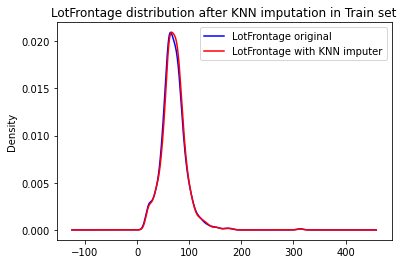

In [117]:
fig = plt.figure()
ax = fig.add_subplot(111)

X_train_imputed['LotFrontage'].plot(kind='kde', ax=ax, color='blue')
df_train_lf['LotFrontage'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['LotFrontage original', 'LotFrontage with KNN imputer']
ax.legend(lines, labels, loc='best')
plt.title('LotFrontage distribution after KNN imputation in Train set')
plt.show()

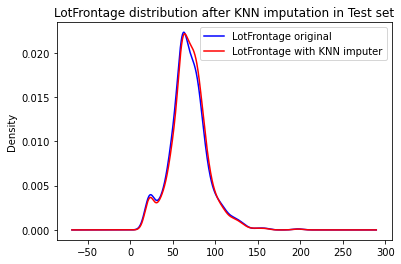

In [118]:
fig = plt.figure()
ax = fig.add_subplot(111)

X_test_imputed['LotFrontage'].plot(kind='kde', ax=ax, color='blue')
df_test_lf['LotFrontage'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['LotFrontage original', 'LotFrontage with KNN imputer']
ax.legend(lines, labels, loc='best')
plt.title('LotFrontage distribution after KNN imputation in Test set')
plt.show()

In [119]:
X_train_imputed['LotFrontage'] = df_train_lf['LotFrontage']
X_train_imputed['LotFrontage'].isna().sum()

0

In [120]:
X_test_imputed.shape

(1459, 78)

In [121]:
X_test_imputed.reset_index(inplace=True)

X_test_imputed['LotFrontage'] = df_test_lf['LotFrontage']
X_test_imputed['LotFrontage'].isna().sum()

0

In [122]:
X_test_ID = X_test_imputed['Id']
X_test_imputed.drop(columns ='Id', inplace=True)

#### Check NA values after handling missing data

In [123]:
X_train_imputed.isna().sum().sort_values(ascending=False)

MSSubClass       0
HalfBath         0
FireplaceQu      0
Fireplaces       0
Functional       0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 78, dtype: int64

In [124]:
X_test_imputed.isna().sum().sort_values(ascending=False)[:10]

MSZoning        4
BsmtFullBath    2
Utilities       2
BsmtHalfBath    2
Functional      2
Exterior2nd     1
KitchenQual     1
SaleType        1
Exterior1st     1
GarageType      0
dtype: int64

#### Dealing missing in Test set

Impute MSZoning with mode

In [125]:
X_test_imputed[X_test_imputed['MSZoning'].isna() == True]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
455,30,NaN,109.000000,21780,Grvl,NA,Reg,Lvl,NaN,Inside,...,0,0,0,NA,NA,0,3,2009,ConLD,Normal
756,20,NaN,80.000000,14584,Pave,NA,Reg,Low,AllPub,Inside,...,0,0,0,NA,NA,0,2,2008,WD,Abnorml
790,70,NaN,88.925207,56600,Pave,NA,IR1,Low,AllPub,Inside,...,0,0,0,NA,NA,0,1,2008,WD,Normal
1444,20,NaN,125.000000,31250,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,5,2006,WD,Normal


In [126]:
MSZoning_mode = X_test_imputed['MSZoning'].mode()
MSZoning_mode[0]

'RL'

In [127]:
X_test_imputed['MSZoning'] = X_test_imputed['MSZoning'].fillna(MSZoning_mode[0])
X_test_imputed['MSZoning'].isna().sum()

0

Mode for Utilities

In [128]:
X_test_imputed['Utilities'] = X_test_imputed['Utilities'].fillna(X_test_imputed['Utilities'].mode()[0])
X_test_imputed['Utilities'].isna().sum()

0

BsmtFullBath and BsmtHalfBath

In [129]:
X_test_imputed['BsmtFullBath'] = X_test_imputed['BsmtFullBath'].fillna(0)
X_test_imputed['BsmtFullBath'].isna().sum()

0

In [130]:
X_test_imputed['BsmtHalfBath'] = X_test_imputed['BsmtHalfBath'].fillna(0)
X_test_imputed['BsmtHalfBath'].isna().sum()

0

Functional with Mode

In [131]:
X_test_imputed['Exterior1st'] = X_test_imputed['Exterior1st'].fillna(X_test_imputed['Exterior1st'].mode()[0])
X_test_imputed['KitchenQual'] = X_test_imputed['KitchenQual'].fillna(X_test_imputed['KitchenQual'].mode()[0])
X_test_imputed['SaleType'] = X_test_imputed['SaleType'].fillna(X_test_imputed['SaleType'].mode()[0])
X_test_imputed['Exterior2nd'] = X_test_imputed['Exterior2nd'].fillna(X_test_imputed['Exterior2nd'].mode()[0])
X_test_imputed['Functional'] = X_test_imputed['Functional'].fillna(X_test_imputed['Functional'].mode()[0])
X_test_imputed['MSSubClass'] = X_test_imputed['MSSubClass'].fillna(X_test_imputed['MSSubClass'].mode()[0])

In [132]:
X_test_imputed.isna().sum().sort_values(ascending=False)

MSSubClass       0
HalfBath         0
FireplaceQu      0
Fireplaces       0
Functional       0
                ..
MasVnrArea       0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
SaleCondition    0
Length: 78, dtype: int64

### Categorical encoding

Get categorical varibles under numeric

In [133]:
for col in numerical_cols:
    if len(X_train_imputed[col].value_counts()) < 30:
        print(f"The feature {col} has {len(X_train_imputed[col].unique())} unique values below:")
        print(f"\t\t {X_train_imputed[col].unique()}")

The feature MSSubClass has 15 unique values below:
		 [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
The feature OverallQual has 10 unique values below:
		 [ 7  6  8  5  9  4 10  3  1  2]
The feature OverallCond has 9 unique values below:
		 [5 8 6 7 4 2 3 9 1]
The feature LowQualFinSF has 24 unique values below:
		 [  0 360 513 234 528 572 144 392 371 390 420 473 156 515  80  53 232 481
 120 514 397 479 205 384]
The feature BsmtFullBath has 4 unique values below:
		 [1. 0. 2. 3.]
The feature BsmtHalfBath has 3 unique values below:
		 [0. 1. 2.]
The feature FullBath has 4 unique values below:
		 [2 1 3 0]
The feature HalfBath has 3 unique values below:
		 [1 0 2]
The feature BedroomAbvGr has 8 unique values below:
		 [3 4 1 2 0 5 6 8]
The feature KitchenAbvGr has 4 unique values below:
		 [1 2 3 0]
The feature TotRmsAbvGrd has 12 unique values below:
		 [ 8  6  7  9  5 11  4 10 12  3  2 14]
The feature Fireplaces has 4 unique values below:
		 [0 1 2 3]
The feature Garage

In [134]:
ignored_cols

['MiscFeature']

In [135]:
#Check unique values of all categorical features
features_more_10_cate = []
for col in categorical_cols:
    no_uniq_value = X_train_imputed[col].unique()
    print(f"The feature {col} has {len(no_uniq_value)} unique values below:")
    print(f"\t\t {no_uniq_value}")
    if len(no_uniq_value) > 10:
        features_more_10_cate.append(col)

The feature MSZoning has 5 unique values below:
		 ['RL' 'RM' 'C (all)' 'FV' 'RH']
The feature Street has 2 unique values below:
		 ['Pave' 'Grvl']
The feature Alley has 3 unique values below:
		 ['NA' 'Grvl' 'Pave']
The feature LotShape has 4 unique values below:
		 ['Reg' 'IR1' 'IR2' 'IR3']
The feature LandContour has 4 unique values below:
		 ['Lvl' 'Bnk' 'Low' 'HLS']
The feature Utilities has 2 unique values below:
		 ['AllPub' 'NoSeWa']
The feature LotConfig has 5 unique values below:
		 ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
The feature LandSlope has 3 unique values below:
		 ['Gtl' 'Mod' 'Sev']
The feature Neighborhood has 25 unique values below:
		 ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
The feature Condition1 has 9 unique values below:
		 ['Norm' 'Feedr' 'PosN' 'Artery' '

In [136]:
len(X_train_imputed['Neighborhood'].unique())

25

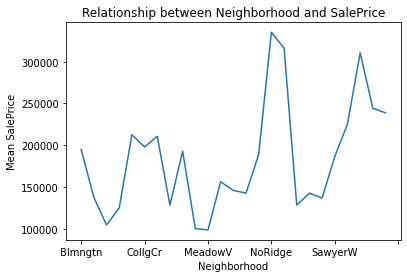

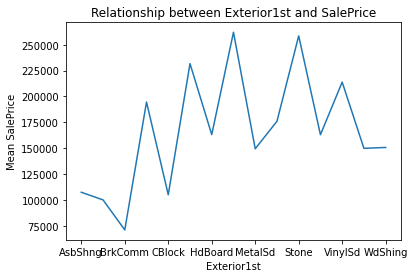

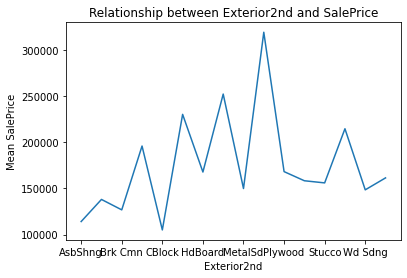

In [137]:
for var in features_more_10_cate:
    fig = plt.figure()
    fig = pd.concat([X_train_imputed, y_train], axis=1).groupby([var])['SalePrice'].mean().plot()
    fig.set_title(f'Relationship between {var} and SalePrice')
    fig.set_ylabel('Mean SalePrice')
    plt.show()

#### Ordered encoding
['Neighborhood', 'Exterior1st', 'Exterior2nd']

##### Neighborhood, Exterior1st and Exterior2nd
This feature has 25 categories, and this feature affects to Target(SalePrice).
So we use Ordered encoding.

Advantages

    - Capture information within the category, therefore creating more predictive features
    - Create a monotonic relationship between the variable and the target, therefore suitable for linear models
    - Do not expand the feature space
    
Limitations

    - Prone to cause over-fitting

In [138]:
ordinal_enc = OrdinalEncoder(
    # NOTE that we indicate ordered in the encoding_method, otherwise it assings numbers arbitrarily
    encoding_method='ordered',
    variables=['Neighborhood', 'Exterior1st', 'Exterior2nd'])


In [139]:
X_train_enc = X_train_imputed.copy()
X_test_enc = X_test_imputed.copy()

In [140]:
ordinal_enc.fit(X_train_enc, y_train)
ordinal_enc.encoder_dict_

{'Neighborhood': {'MeadowV': 0,
  'IDOTRR': 1,
  'BrDale': 2,
  'BrkSide': 3,
  'Edwards': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'Blueste': 7,
  'SWISU': 8,
  'NPkVill': 9,
  'NAmes': 10,
  'Mitchel': 11,
  'SawyerW': 12,
  'NWAmes': 13,
  'Gilbert': 14,
  'Blmngtn': 15,
  'CollgCr': 16,
  'Crawfor': 17,
  'ClearCr': 18,
  'Somerst': 19,
  'Veenker': 20,
  'Timber': 21,
  'StoneBr': 22,
  'NridgHt': 23,
  'NoRidge': 24},
 'Exterior1st': {'BrkComm': 0,
  'AsphShn': 1,
  'CBlock': 2,
  'AsbShng': 3,
  'MetalSd': 4,
  'Wd Sdng': 5,
  'WdShing': 6,
  'Stucco': 7,
  'HdBoard': 8,
  'Plywood': 9,
  'BrkFace': 10,
  'VinylSd': 11,
  'CemntBd': 12,
  'Stone': 13,
  'ImStucc': 14},
 'Exterior2nd': {'CBlock': 0,
  'AsbShng': 1,
  'Brk Cmn': 2,
  'AsphShn': 3,
  'Wd Sdng': 4,
  'MetalSd': 5,
  'Stucco': 6,
  'Stone': 7,
  'Wd Shng': 8,
  'HdBoard': 9,
  'Plywood': 10,
  'BrkFace': 11,
  'VinylSd': 12,
  'CmentBd': 13,
  'ImStucc': 14,
  'Other': 15}}

In [141]:
X_train_enc = ordinal_enc.transform(X_train_enc)
X_train_enc[features_more_10_cate]

,Neighborhood,Exterior1st,Exterior2nd
0,16,11,12
1,20,4,5
2,16,11,12
3,17,5,8
4,24,11,12
...,...,...,...
1454,14,11,12
1455,13,9,10
1456,17,12,13
1457,10,4,5


In [142]:
X_train_enc.shape

(1459, 78)

In [143]:
X_test_enc = ordinal_enc.transform(X_test_enc)
X_test_enc[features_more_10_cate]

,Neighborhood,Exterior1st,Exterior2nd
0,10,11,12
1,10,5,4
2,14,11,12
3,14,11,12
4,22,8,9
...,...,...,...
1454,0,12,13
1455,0,12,13
1456,11,11,12
1457,11,8,8


In [144]:
X_test_enc.isna().sum()

MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 78, dtype: int64

In [145]:
X_train_enc.index

RangeIndex(start=0, stop=1459, step=1)

In [146]:
X_test_enc.index

RangeIndex(start=0, stop=1459, step=1)

In [147]:
X_train_enc.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,0,0,NA,NA,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,0,NA,NA,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,0,NA,NA,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,0,0,0,NA,NA,0,12,2008,WD,Normal


In [148]:
categorical_cols

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleType',
       'SaleCondition'],
      dtype='object')

#### Check mismatch labels between train and test sets

We make sure all labels in test set has been covered in Train set

In [149]:
check_cate_train_vs_test(X_train_enc, X_test_enc, categorical_cols)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()


#### Check rare labels

In [150]:
features_less_10_cate = set(categorical_cols) - set(features_more_10_cate) - set(ignored_cols)
#features_less_10_cate

In [151]:
rare_cols = check_rare_labels(X_train_enc, features_less_10_cate)
#rare_cols

Group features which has more than 2 rare labels into one label

In [152]:
rare_grp_cols = {}
for col in rare_cols.keys():
    if len(rare_cols[col]) > 1:
        rare_grp_cols[col] = list(rare_cols[col].index)
print(rare_grp_cols)

{'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 0, 'LwQ', 'Rec'], 'GarageQual': ['Ex', 'Po', 'Gd', 'Fa'], 'HouseStyle': ['2.5Fin', '2.5Unf', '1.5Unf', 'SFoyer', 'SLvl'], 'RoofMatl': ['Metal', 'Membran', 'Roll', 'ClyTile', 'WdShake', 'WdShngl', 'Tar&Grv'], 'Electrical': ['Mix', 'FuseP', 'FuseF'], 'GarageType': ['2Types', 'CarPort', 'Basment'], 'PoolQC': ['Ex', 'Fa', 'Gd'], 'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min1', 'Min2'], 'BsmtCond': ['Po', 'NA', 'Fa', 'Gd'], 'MSZoning': ['C (all)', 'RH', 'FV'], 'Fence': ['MnWw', 'GdWo', 'GdPrv'], 'Alley': ['Pave', 'Grvl'], 'Condition2': ['PosA', 'RRAn', 'RRAe', 'Artery', 'RRNn', 'PosN', 'Feedr'], 'Heating': ['Floor', 'OthW', 'Wall', 'Grav', 'GasW'], 'LotConfig': ['FR3', 'FR2'], 'Condition1': ['RRNe', 'RRNn', 'PosA', 'RRAe', 'PosN', 'RRAn', 'Artery'], 'ExterQual': ['Fa', 'Ex'], 'SaleType': ['Con', 'Oth', 'CWD', 'ConLI', 'ConLw', 'ConLD', 'COD'], 'SaleCondition': ['AdjLand', 'Alloca', 'Family'], 'Foundation': ['Wood', 'Stone', 'Slab'], 'LandContour': 

In [153]:
X_train_rare = X_train_enc.copy()
for col in rare_grp_cols:
    X_train_rare[col].replace(rare_grp_cols[col], 'RARE', inplace=True)
    print(X_train_rare[col].unique())

['Unf' 'RARE']
['TA' 'RARE' 'NA']
['2Story' '1Story' '1.5Fin' 'RARE']
['CompShg' 'RARE']
['SBrkr' 'RARE' 'FuseA']
['Attchd' 'Detchd' 'BuiltIn' 'RARE' 'NA']
['NA' 'RARE']
['Typ' 'RARE']
['TA' 'RARE']
['RL' 'RM' 'RARE']
['NA' 'MnPrv' 'RARE']
['NA' 'RARE']
['Norm' 'RARE']
['GasA' 'RARE']
['Inside' 'RARE' 'Corner' 'CulDSac']
['Norm' 'Feedr' 'RARE']
['Gd' 'TA' 'RARE']
['WD' 'New' 'RARE']
['Normal' 'Abnorml' 'Partial' 'RARE']
['PConc' 'CBlock' 'BrkTil' 'RARE']
['Lvl' 'RARE']
['TA' 'Gd' 'RARE']
['Gtl' 'RARE']
['NA' 'TA' 'Gd' 'RARE']
['Gd' 'TA' 'Ex' 'RARE']
['Ex' 'Gd' 'TA' 'RARE']
['1Fam' 'RARE' 'TwnhsE']
['TA' 'RARE' 'NA']
['Gable' 'Hip' 'RARE']
['Reg' 'IR1' 'RARE']


In [154]:
X_test_rare = X_test_enc.copy()
for col in rare_grp_cols:
    X_test_rare[col].replace(rare_grp_cols[col], 'RARE', inplace=True)
    print(X_test_rare[col].unique())

['RARE' 'Unf']
['TA' 'NA' 'RARE']
['1Story' '2Story' 'RARE' '1.5Fin']
['CompShg' 'RARE']
['SBrkr' 'FuseA' 'RARE']
['Attchd' 'Detchd' 'BuiltIn' 'NA' 'RARE']
['NA' 'RARE']
['Typ' 'RARE']
['TA' 'RARE']
['RARE' 'RL' 'RM']
['MnPrv' 'NA' 'RARE']
['NA' 'RARE']
['Norm' 'RARE']
['GasA' 'RARE']
['Inside' 'Corner' 'RARE' 'CulDSac']
['Feedr' 'Norm' 'RARE']
['TA' 'Gd' 'RARE']
['WD' 'RARE' 'New']
['Normal' 'Partial' 'Abnorml' 'RARE']
['CBlock' 'PConc' 'BrkTil' 'RARE']
['Lvl' 'RARE']
['TA' 'Gd' 'RARE']
['Gtl' 'RARE']
['NA' 'TA' 'Gd' 'RARE']
['TA' 'Gd' 'Ex' 'RARE']
['TA' 'Gd' 'Ex' 'RARE']
['1Fam' 'TwnhsE' 'RARE']
['TA' 'NA' 'RARE']
['Gable' 'Hip' 'RARE']
['Reg' 'IR1' 'RARE']


In [155]:
rare_grp_cols

{'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 0, 'LwQ', 'Rec'],
 'GarageQual': ['Ex', 'Po', 'Gd', 'Fa'],
 'HouseStyle': ['2.5Fin', '2.5Unf', '1.5Unf', 'SFoyer', 'SLvl'],
 'RoofMatl': ['Metal',
  'Membran',
  'Roll',
  'ClyTile',
  'WdShake',
  'WdShngl',
  'Tar&Grv'],
 'Electrical': ['Mix', 'FuseP', 'FuseF'],
 'GarageType': ['2Types', 'CarPort', 'Basment'],
 'PoolQC': ['Ex', 'Fa', 'Gd'],
 'Functional': ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min1', 'Min2'],
 'BsmtCond': ['Po', 'NA', 'Fa', 'Gd'],
 'MSZoning': ['C (all)', 'RH', 'FV'],
 'Fence': ['MnWw', 'GdWo', 'GdPrv'],
 'Alley': ['Pave', 'Grvl'],
 'Condition2': ['PosA', 'RRAn', 'RRAe', 'Artery', 'RRNn', 'PosN', 'Feedr'],
 'Heating': ['Floor', 'OthW', 'Wall', 'Grav', 'GasW'],
 'LotConfig': ['FR3', 'FR2'],
 'Condition1': ['RRNe', 'RRNn', 'PosA', 'RRAe', 'PosN', 'RRAn', 'Artery'],
 'ExterQual': ['Fa', 'Ex'],
 'SaleType': ['Con', 'Oth', 'CWD', 'ConLI', 'ConLw', 'ConLD', 'COD'],
 'SaleCondition': ['AdjLand', 'Alloca', 'Family'],
 'Foundation': ['Wood', 'S

Double-check rare labels after grouping rare labels into 'RARE'

In [156]:
X_train_rare['BsmtFinType2'].value_counts()

Unf     1255
RARE     204
Name: BsmtFinType2, dtype: int64

For MSZoning we dont using onehot encoding, we use mean encoding

In [157]:
features_less_10_cate = set(features_less_10_cate) - set('MSZoning')

In [158]:
rare_cols = check_rare_labels(X_train_rare, features_less_10_cate)
rare_grp_cols = {}
for col in rare_cols.keys():
    if len(rare_cols[col]) > 1:
        rare_grp_cols[col] = list(rare_cols[col].index)
print(rare_grp_cols)

{}


#### One-hot encoding

In [159]:
X_train_onhenc = X_train_rare.copy()


In [160]:
X_test_onhenc = X_test_rare.copy()


In [161]:
onh_encoding = OneHotEncoder(
    top_categories=None,
    variables=list(features_less_10_cate),
    drop_last=True)


In [162]:
onh_encoding.fit(X_train_onhenc)

OneHotEncoder(drop_last=True,
              variables=['BsmtFinType2', 'GarageQual', 'CentralAir',
                         'HouseStyle', 'RoofMatl', 'Electrical', 'KitchenQual',
                         'GarageType', 'PoolQC', 'Functional', 'BsmtCond',
                         'MSZoning', 'Fence', 'Alley', 'Condition2',
                         'GarageFinish', 'Utilities', 'Heating', 'LotConfig',
                         'Condition1', 'ExterQual', 'SaleType', 'SaleCondition',
                         'Foundation', 'LandContour', 'ExterCond',
                         'BsmtExposure', 'BsmtFinType1', 'MasVnrType',
                         'LandSlope', ...])

In [163]:
X_train_onhenc = onh_encoding.transform(X_train_onhenc)
X_train_onhenc.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,BldgType_1Fam,BldgType_RARE,GarageCond_TA,GarageCond_RARE,RoofStyle_Gable,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1
0,60,65.0,8450,16,7,5,2003,2003,11,12,...,1,0,1,0,1,0,1,0,1,0
1,20,80.0,9600,20,6,8,1976,1976,4,5,...,1,0,1,0,1,0,1,0,1,0
2,60,68.0,11250,16,7,5,2001,2002,11,12,...,1,0,1,0,1,0,1,0,0,1
3,70,60.0,9550,17,7,5,1915,1970,5,8,...,1,0,1,0,1,0,1,0,0,1
4,60,84.0,14260,24,8,5,2000,2000,11,12,...,1,0,1,0,1,0,1,0,0,1


In [164]:
X_test_onhenc = onh_encoding.transform(X_test_onhenc)
X_test_onhenc.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,BldgType_1Fam,BldgType_RARE,GarageCond_TA,GarageCond_RARE,RoofStyle_Gable,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1
0,20,80.0,11622,10,5,6,1961,1961,11,12,...,1,0,1,0,1,0,1,0,1,0
1,20,81.0,14267,10,6,6,1958,1958,5,4,...,1,0,1,0,0,1,1,0,0,1
2,60,74.0,13830,14,5,5,1997,1998,11,12,...,1,0,1,0,1,0,1,0,0,1
3,60,78.0,9978,14,6,6,1998,1998,11,12,...,1,0,1,0,1,0,1,0,0,1
4,120,43.0,5005,22,8,5,1992,1992,8,9,...,0,0,1,0,1,0,1,0,0,1


In [165]:
X_train_onhenc.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('int32')], dtype=object)

In [166]:
new_enc_features = X_train_onhenc.columns
print(f"Original dataset has {len(X_train.columns)}, after categorical encoding, there are {len(new_enc_features)}")

Original dataset has 79, after categorical encoding, there are 122


In [167]:
for col in new_enc_features:
    if "MSZoning" in col:
        print(col)

MSZoning_RL
MSZoning_RM


#### Mean encoding
MSSubClass

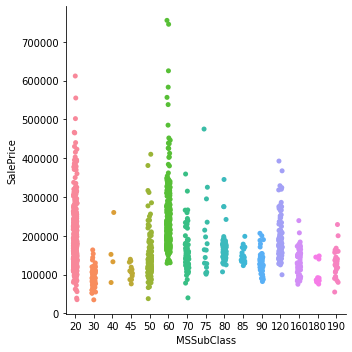

In [168]:
sns.catplot(data=df_train, x="MSSubClass", y="SalePrice")

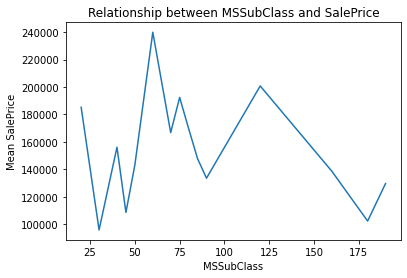

In [169]:
fig = plt.figure()
fig = df_train.groupby(['MSSubClass'])['SalePrice'].mean().plot()
fig.set_title(f'Relationship between MSSubClass and SalePrice')
fig.set_ylabel('Mean SalePrice')
plt.show()

In [170]:
mean_enc = MeanEncoder(
    variables=['MSSubClass'])

X_train_onhenc['MSSubClass'] = X_train_onhenc['MSSubClass'].astype(str)
mean_enc.fit(X_train_onhenc, y_train)

MeanEncoder(variables=['MSSubClass'])

In [171]:
X_train_onhenc['MSSubClass']

0       60
1       20
2       60
3       70
4       60
        ..
1454    60
1455    20
1456    70
1457    20
1458    20
Name: MSSubClass, Length: 1459, dtype: object

In [172]:
mean_enc.encoder_dict_

{'MSSubClass': {'120': 200779.0804597701,
  '160': 138647.38095238095,
  '180': 102300.0,
  '190': 129613.33333333333,
  '20': 185224.81156716417,
  '30': 95829.72463768115,
  '40': 156125.0,
  '45': 108591.66666666667,
  '50': 143302.97222222222,
  '60': 239948.5016722408,
  '70': 166772.41666666666,
  '75': 192437.5,
  '80': 169775.7894736842,
  '85': 147810.0,
  '90': 133541.07692307694}}

In [173]:
X_train_meanenc = X_train_onhenc.copy()
X_train_meanenc = mean_enc.transform(X_train_meanenc)
X_train_meanenc['MSSubClass']

0       239948.501672
1       185224.811567
2       239948.501672
3       166772.416667
4       239948.501672
            ...      
1454    239948.501672
1455    185224.811567
1456    166772.416667
1457    185224.811567
1458    185224.811567
Name: MSSubClass, Length: 1459, dtype: float64

In [174]:
X_test_onhenc['MSSubClass'] = X_test_onhenc['MSSubClass'].astype(str)

X_test_meanenc = mean_enc.transform(X_test_onhenc)
X_test_meanenc['MSSubClass']

C:\Python3\lib\site-packages\feature_engine\encoding\base_encoder.py:238: UserWarning: During the encoding, NaN values were introduced in the feature(s) MSSubClass.
  warnings.warn(


0       185224.811567
1       185224.811567
2       239948.501672
3       239948.501672
4       200779.080460
            ...      
1454    138647.380952
1455    138647.380952
1456    185224.811567
1457    147810.000000
1458    239948.501672
Name: MSSubClass, Length: 1459, dtype: float64

In [175]:
X_train_meanenc.shape

(1459, 122)

In [176]:
X_test_meanenc.shape

(1459, 122)

In [177]:
X_test_meanenc['MSSubClass'] = X_test_meanenc['MSSubClass'].fillna(X_test_meanenc['MSSubClass'].mode()[0])
X_test_meanenc['MSSubClass'].isna().sum()

0

### Outlier

In [178]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.05)
    quartile3 = dataframe[variable].quantile(0.95)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names

In [179]:
X_train_meanenc_no_handle_outlier = X_train_meanenc.copy()
y_train_no_handle_outlier = y_train.copy()

X_test_meanenc_no_handle_outlier = X_test_meanenc.copy()

**LotArea**

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


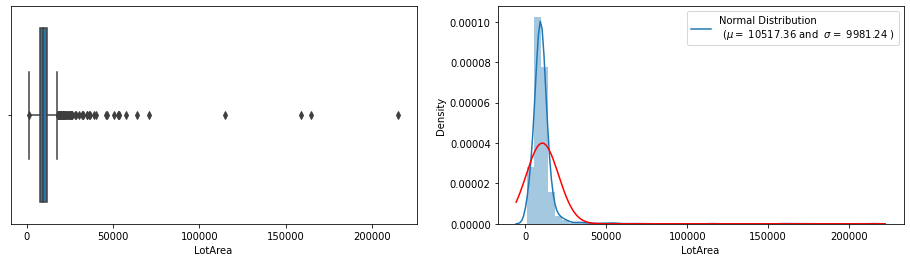

In [180]:
plot_distributions(X_train_meanenc['LotArea'])

In [181]:
(mu, sigma) = stats.norm.fit(df_train['LotArea'])
(mu, sigma)

(10517.363947909527, 9981.243930909777)

In [182]:
lotarea_low_limit, lotarea_up_limit = round(mu -3 * sigma, 4), round(mu + 3 * sigma, 4)
lotarea_low_limit, lotarea_up_limit

(-19426.3678, 40461.0957)

In [183]:
X_train_meanenc[X_train_meanenc['LotArea'] > lotarea_up_limit]

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,BldgType_1Fam,BldgType_RARE,GarageCond_TA,GarageCond_RARE,RoofStyle_Gable,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1
53,185224.811567,68.000000,50271,20,9,5,1981,1987,6,8,...,1,0,1,0,1,0,1,0,0,1
249,143302.972222,132.482781,159000,18,6,7,1958,2006,5,9,...,1,0,1,0,1,0,1,0,0,0
313,185224.811567,150.000000,215245,21,7,5,1965,1965,10,11,...,1,0,1,0,0,1,1,0,0,0
335,129613.333333,133.318723,164660,21,5,6,1965,1965,9,10,...,0,1,1,0,1,0,1,0,0,1
384,239948.501672,60.321001,53107,18,6,5,1992,1992,8,9,...,1,0,1,0,1,0,1,0,0,0
451,185224.811567,62.000000,70761,18,7,5,1975,1975,9,10,...,1,0,1,0,1,0,1,0,0,1
457,185224.811567,71.530398,53227,18,4,6,1954,1994,9,10,...,1,0,1,0,0,0,1,0,0,1
661,239948.501672,52.000000,46589,24,8,7,1994,2005,11,12,...,1,0,1,0,0,1,1,0,0,0
706,185224.811567,113.603838,115149,18,7,5,1971,2002,9,10,...,1,0,1,0,1,0,1,0,0,0
769,239948.501672,47.000000,53504,22,8,5,2003,2003,12,8,...,1,0,1,0,0,1,1,0,0,0


**Set outliers values to it's limit**

In [184]:
X_train_meanenc['LotArea'] = X_train_meanenc['LotArea'].apply(lambda x: x if x < lotarea_up_limit else lotarea_up_limit)

X_test_meanenc['LotArea'] = X_test_meanenc['LotArea'].apply(lambda x: x if x < lotarea_up_limit else lotarea_up_limit)

**SalePrice**

In [185]:
# plot_distributions(df_train['SalePrice'])

SalePrice : 2


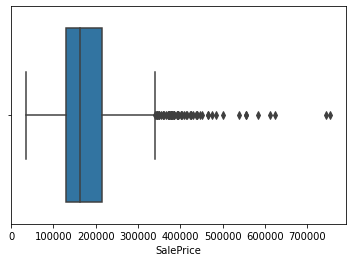

['SalePrice']

In [186]:
has_outliers(df_train, ['SalePrice'], plot=True) 

In [187]:
sp_low_limit, sp_up_limit = outlier_thresholds(df_train, 'SalePrice')
sp_low_limit, sp_up_limit

(-269299.99999999977, 683499.9999999995)

In [188]:
y_train[y_train >= sp_up_limit]

691     755000
1182    745000
Name: SalePrice, dtype: int64

In [189]:
df_train[df_train['SalePrice'] > sp_up_limit]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [190]:
#y_train = y_train.apply(lambda x: x if x < sp_up_limit else sp_up_limit)

**BsmtFinSF1**

BsmtFinSF1 : 1


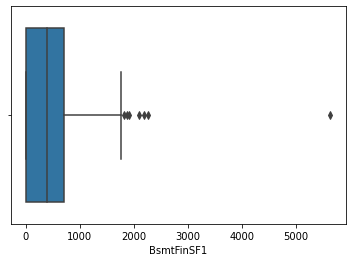

['BsmtFinSF1']

In [191]:
has_outliers(X_train_meanenc, ['BsmtFinSF1'], plot=True)

In [192]:
bsfs1_low_limit, bsfs1_up_limit = outlier_thresholds(X_train_meanenc, 'BsmtFinSF1')
bsfs1_low_limit, bsfs1_up_limit


(-1911.0, 3185.0)

In [193]:
df_train[df_train['BsmtFinSF1'] > bsfs1_up_limit]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [194]:
X_train_meanenc[X_train_meanenc['BsmtFinSF1'] >= bsfs1_up_limit]

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,BldgType_1Fam,BldgType_RARE,GarageCond_TA,GarageCond_RARE,RoofStyle_Gable,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1
1298,239948.501672,313.0,40461.0957,4,10,5,2008,2008,7,6,...,1,0,1,0,0,1,1,0,0,0


In [195]:
X_train_meanenc['BsmtFinSF1'] = X_train_meanenc['BsmtFinSF1'].apply(lambda x: x if x < bsfs1_up_limit else bsfs1_up_limit)

X_test_meanenc['BsmtFinSF1'] = X_train_meanenc['BsmtFinSF1'].apply(lambda x: x if x < bsfs1_up_limit else bsfs1_up_limit)

**TotalBsmtSF**

TotalBsmtSF : 1


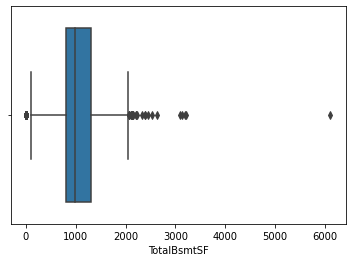

['TotalBsmtSF']

In [196]:
has_outliers(X_train_meanenc, ['TotalBsmtSF'], plot=True)

In [197]:
ttbsfs_low_limit, ttbsfs_up_limit = outlier_thresholds(X_train_meanenc, 'TotalBsmtSF')
ttbsfs_low_limit, ttbsfs_up_limit

(-1329.5, 3602.5)

In [198]:
X_train_meanenc['TotalBsmtSF'] = X_train_meanenc['TotalBsmtSF'].apply(lambda x: x if x < ttbsfs_up_limit else ttbsfs_up_limit)

X_test_meanenc['TotalBsmtSF'] = X_test_meanenc['TotalBsmtSF'].apply(lambda x: x if x < ttbsfs_up_limit else ttbsfs_up_limit)

In [199]:

print(f"shape of X_train_meanenc is {X_train_meanenc.shape}, y_train is {y_train.shape}")

shape of X_train_meanenc is (1459, 122), y_train is (1459,)


**GrLivArea**

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Python3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


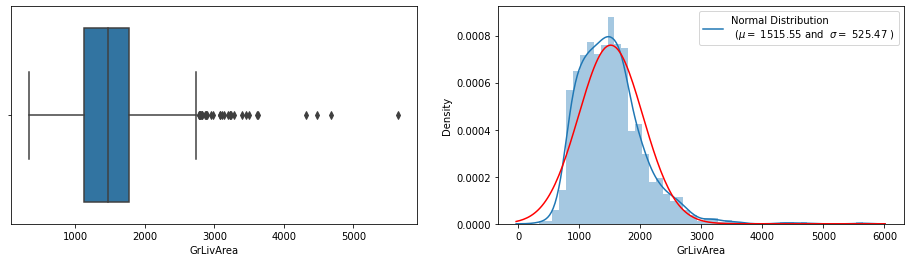

In [200]:
plot_distributions(X_train_meanenc['GrLivArea'])

In [201]:
glarea_low_limit, glarea_up_limit = outlier_thresholds(X_train_meanenc, 'GrLivArea')
glarea_low_limit, glarea_up_limit

(-1579.2999999999997, 4893.5)

In [202]:
(mu, sigma) = stats.norm.fit(df_train['GrLivArea'])
(mu, sigma)
glarea_low_limit, glarea_up_limit = round(mu -3 * sigma, 4), round(mu + 3 * sigma, 4)
glarea_low_limit, glarea_up_limit

(-60.8653, 3091.9592)

In [203]:
X_train_meanenc['GrLivArea'] = X_train_meanenc['GrLivArea'].apply(lambda x: x if x < glarea_up_limit else glarea_up_limit)

X_test_meanenc['GrLivArea'] = X_test_meanenc['GrLivArea'].apply(lambda x: x if x < glarea_up_limit else glarea_up_limit)

### Feature creation

In [204]:
X_test_id = X_test.index
X_test_id

Int64Index([1461, 1462, 1463, 1464, 1465, 1466, 1467, 1468, 1469, 1470,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=1459)

In [205]:
X_train_meanenc['YrBltAndRemod']=X_train_meanenc['YearBuilt']+X_train_meanenc['YearRemodAdd']
X_train_meanenc['TotalSF']=X_train_meanenc['TotalBsmtSF'] + X_train_meanenc['1stFlrSF'] + X_train_meanenc['2ndFlrSF']

X_train_meanenc['Total_sqr_footage'] = (X_train_meanenc['BsmtFinSF1'] + X_train_meanenc['BsmtFinSF2'] +
                                 X_train_meanenc['1stFlrSF'] + X_train_meanenc['2ndFlrSF'])

X_train_meanenc['Total_Bathrooms'] = (X_train_meanenc['FullBath'] + (0.5 * X_train_meanenc['HalfBath']) +
                               X_train_meanenc['BsmtFullBath'] + (0.5 * X_train_meanenc['BsmtHalfBath']))

X_train_meanenc['Total_porch_sf'] = (X_train_meanenc['OpenPorchSF'] + X_train_meanenc['3SsnPorch'] +
                              X_train_meanenc['EnclosedPorch'] + X_train_meanenc['ScreenPorch'] +
                              X_train_meanenc['WoodDeckSF'])

In [206]:
X_test_meanenc['YrBltAndRemod']=X_test_meanenc['YearBuilt']+X_test_meanenc['YearRemodAdd']
X_test_meanenc['TotalSF']=X_test_meanenc['TotalBsmtSF'] + X_test_meanenc['1stFlrSF'] + X_test_meanenc['2ndFlrSF']

X_test_meanenc['Total_sqr_footage'] = (X_test_meanenc['BsmtFinSF1'] + X_test_meanenc['BsmtFinSF2'] +
                                 X_test_meanenc['1stFlrSF'] + X_test_meanenc['2ndFlrSF'])

X_test_meanenc['Total_Bathrooms'] = (X_test_meanenc['FullBath'] + (0.5 * X_test_meanenc['HalfBath']) +
                               X_test_meanenc['BsmtFullBath'] + (0.5 * X_test_meanenc['BsmtHalfBath']))

X_test_meanenc['Total_porch_sf'] = (X_test_meanenc['OpenPorchSF'] + X_test_meanenc['3SsnPorch'] +
                              X_test_meanenc['EnclosedPorch'] + X_test_meanenc['ScreenPorch'] +
                              X_test_meanenc['WoodDeckSF'])

In [207]:
numerical_cols = list(numerical_cols) + ['YrBltAndRemod', 'TotalSF', 'Total_sqr_footage', 'Total_Bathrooms', 'Total_porch_sf']
numerical_cols

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'YrBltAndRemod',
 'TotalSF',
 'Total_sqr_footage',
 'Total_Bathrooms',
 'Total_porch_sf']

### Feature scaling

In [208]:
X_train_meanenc.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_train_meanenc

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,239948.501672,65.0,8450.0,16,7,5,2003,2003,11,12,...,0,1,0,1,0,4006,2566.0,2416.0,3.5,61
1,185224.811567,80.0,9600.0,20,6,8,1976,1976,4,5,...,0,1,0,1,0,3952,2524.0,2240.0,2.5,298
2,239948.501672,68.0,11250.0,16,7,5,2001,2002,11,12,...,0,1,0,0,1,4003,2706.0,2272.0,3.5,42
3,166772.416667,60.0,9550.0,17,7,5,1915,1970,5,8,...,0,1,0,0,1,3885,2473.0,1933.0,2.0,307
4,239948.501672,84.0,14260.0,24,8,5,2000,2000,11,12,...,0,1,0,0,1,4000,3343.0,2853.0,3.5,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,239948.501672,62.0,7917.0,14,6,5,1999,2000,11,12,...,0,1,0,1,0,3999,2600.0,1647.0,2.5,40
1455,185224.811567,85.0,13175.0,13,6,6,1978,1988,9,10,...,0,1,0,1,0,3966,3615.0,3026.0,3.0,349
1456,166772.416667,66.0,9042.0,17,7,9,1941,2006,12,13,...,0,1,0,1,0,3947,3492.0,2615.0,2.0,60
1457,185224.811567,68.0,9717.0,10,5,6,1950,1996,4,5,...,1,1,0,1,0,3946,2156.0,2156.0,2.0,478


In [209]:
X_test_meanenc[numerical_cols]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,185224.811567,80.0,11622.0,5,6,1961,1961,0.0,706.0,144.0,...,120,0,0,6,2010,3922,1778.0,1746.0,1.0,260
1,185224.811567,81.0,14267.0,6,6,1958,1958,108.0,978.0,0.0,...,0,0,12500,6,2010,3916,2658.0,2307.0,1.5,429
2,239948.501672,74.0,13830.0,5,5,1997,1998,0.0,486.0,0.0,...,0,0,0,3,2010,3995,2557.0,2115.0,2.5,246
3,239948.501672,78.0,9978.0,6,6,1998,1998,20.0,216.0,0.0,...,0,0,0,6,2010,3996,2530.0,1820.0,2.5,396
4,200779.080460,43.0,5005.0,8,5,1992,1992,0.0,655.0,0.0,...,144,0,0,1,2010,3984,2560.0,1935.0,2.0,226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,138647.380952,21.0,1936.0,4,7,1970,1970,0.0,0.0,0.0,...,0,0,0,6,2006,3940,1638.0,1092.0,1.5,0
1455,138647.380952,21.0,1894.0,4,5,1970,1970,0.0,790.0,0.0,...,0,0,0,4,2006,3940,1638.0,1882.0,1.5,24
1456,185224.811567,160.0,20000.0,5,7,1960,1996,0.0,275.0,0.0,...,0,0,0,9,2006,3956,2448.0,1499.0,2.0,474
1457,147810.000000,62.0,10441.0,5,5,1992,1992,0.0,49.0,0.0,...,0,0,700,7,2006,3984,1882.0,1019.0,1.5,112


#### StandardScaler

In [210]:
X_train_scaled = X_train_meanenc.reset_index(drop=True).copy()

scaler = StandardScaler()
X_train_num_scaled =  scaler.fit_transform(X_train_scaled[numerical_cols])

X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns=numerical_cols)


In [211]:
X_train_scaled[numerical_cols] = X_train_num_scaled[numerical_cols]
X_train_scaled.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,1.496935,-0.245682,-0.314091,16,0.650852,-0.517424,1.051899,0.879449,11,12,...,0,1,0,1,0,1.095413,0.000161,0.552141,1.642022,-0.768539
1,0.108924,0.384642,-0.093966,20,-0.072372,2.178727,0.157540,-0.428864,4,5,...,0,1,0,1,0,-0.089875,-0.052034,0.319361,0.368724,0.744469
2,1.496935,-0.119617,0.221867,16,0.650852,-0.517424,0.985650,0.830993,11,12,...,0,1,0,0,1,1.029563,0.174141,0.361685,1.642022,-0.889835
3,-0.359103,-0.455790,-0.103536,17,0.650852,-0.517424,-1.863050,-0.719600,5,8,...,0,1,0,0,1,-1.560510,-0.115412,-0.086682,-0.267925,0.801925
4,1.496935,0.552729,0.798022,24,1.374077,-0.517424,0.952526,0.734081,11,12,...,0,1,0,0,1,0.963714,0.965751,1.130124,1.642022,0.604021


In [212]:
X_test_scaled = X_test_meanenc.reset_index(drop=True).copy()

X_test_num_scaled =  scaler.transform(X_test_scaled[numerical_cols])

X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns=numerical_cols)


X_test_scaled[numerical_cols] = X_test_num_scaled[numerical_cols]
X_test_scaled

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,0.108924,0.384642,0.293073,10,-0.795596,0.381293,-0.339327,-1.155705,11,12,...,0,1,0,1,0,-0.748369,-0.979100,-0.334010,-1.541223,0.501877
1,0.108924,0.426664,0.799362,10,-0.072372,0.381293,-0.438700,-1.301073,5,4,...,1,1,0,0,1,-0.880067,0.114490,0.407976,-0.904574,1.580773
2,1.496935,0.132513,0.715714,14,-0.795596,-0.517424,0.853153,0.637169,11,12,...,0,1,0,0,1,0.853965,-0.011024,0.154034,0.368724,0.412501
3,1.496935,0.300599,-0.021611,14,-0.072372,0.381293,0.886277,0.637169,11,12,...,0,1,0,0,1,0.875915,-0.044577,-0.236137,0.368724,1.370101
4,0.503442,-1.170157,-0.973511,22,1.374077,-0.517424,0.687530,0.346432,8,9,...,0,1,0,0,1,0.612518,-0.007296,-0.084036,-0.267925,0.284821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,-1.072466,-2.094632,-1.560960,0,-1.518821,1.280010,-0.041207,-0.719600,12,13,...,0,1,0,1,0,-0.353273,-1.153080,-1.199000,-0.904574,-1.157963
1455,-1.072466,-2.094632,-1.568999,0,-1.518821,-0.517424,-0.041207,-0.719600,12,13,...,0,1,0,1,0,-0.353273,-1.153080,-0.154135,-0.904574,-1.004747
1456,0.108924,3.746371,1.896736,11,-0.795596,1.280010,-0.372451,0.540256,11,12,...,0,1,0,1,0,-0.002076,-0.146480,-0.660696,-0.267925,1.868053
1457,-0.840065,-0.371746,0.067013,11,-0.795596,-0.517424,0.687530,0.346432,8,8,...,0,1,0,1,0,0.612518,-0.849857,-1.295551,-0.904574,-0.442955


#### MinMaxScaler

In [213]:
X_train_mmscaled = X_train_meanenc.reset_index(drop=True).copy()

mm_scaler = MinMaxScaler()
X_train_num_mmscaled =  mm_scaler.fit_transform(X_train_mmscaled[numerical_cols])

X_train_num_mmscaled = pd.DataFrame(X_train_num_mmscaled, columns=numerical_cols)


In [214]:
X_train_mmscaled[numerical_cols] = X_train_num_mmscaled[numerical_cols]
X_train_mmscaled

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,1.000000,0.150685,0.182579,16,0.666667,0.500,0.949275,0.883333,11,12,...,0,1,0,1,0,0.926316,0.250491,0.245143,0.5,0.059396
1,0.620288,0.202055,0.211945,20,0.555556,0.875,0.753623,0.433333,4,5,...,0,1,0,1,0,0.642105,0.245777,0.224420,0.3,0.290166
2,1.000000,0.160959,0.254079,16,0.666667,0.500,0.934783,0.866667,11,12,...,0,1,0,0,1,0.910526,0.266203,0.228188,0.5,0.040896
3,0.492252,0.133562,0.210668,17,0.666667,0.500,0.311594,0.333333,5,8,...,0,1,0,0,1,0.289474,0.240054,0.188273,0.2,0.298929
4,1.000000,0.215753,0.330941,24,0.777778,0.500,0.927536,0.833333,11,12,...,0,1,0,0,1,0.894737,0.337691,0.296597,0.5,0.268744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,1.000000,0.140411,0.168969,14,0.555556,0.500,0.920290,0.833333,11,12,...,0,1,0,1,0,0.889474,0.254307,0.154598,0.3,0.038948
1455,0.620288,0.219178,0.303235,13,0.555556,0.625,0.768116,0.633333,9,10,...,0,1,0,1,0,0.715789,0.368217,0.316967,0.4,0.339825
1456,0.492252,0.154110,0.197696,17,0.666667,1.000,0.500000,0.933333,12,13,...,0,1,0,1,0,0.615789,0.354413,0.268574,0.2,0.058423
1457,0.620288,0.160959,0.214933,10,0.444444,0.625,0.565217,0.766667,4,5,...,1,1,0,1,0,0.610526,0.204478,0.214530,0.2,0.465433


#### RobustScaler

In [215]:
X_train_rbscaled = X_train_meanenc.reset_index(drop=True).copy()

rb_scaler = RobustScaler()
X_train_num_rbscaled =  rb_scaler.fit_transform(X_train_rbscaled[numerical_cols])

X_train_num_rbscaled = pd.DataFrame(X_train_num_rbscaled, columns=numerical_cols)


In [216]:
X_train_rbscaled[numerical_cols] = X_train_num_rbscaled[numerical_cols]
X_train_rbscaled

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,YrBltAndRemod,TotalSF,Total_sqr_footage,Total_Bathrooms,Total_porch_sf
0,0.952112,-0.238095,-0.253330,16,0.5,0.0,0.652174,0.243243,11,12,...,0,1,0,1,0,0.645570,0.091641,0.619529,3.0,-0.466063
1,0.000000,0.476190,0.030340,20,0.0,3.0,0.065217,-0.486486,4,5,...,0,1,0,1,0,-0.037975,0.049345,0.421998,1.0,0.606335
2,0.952112,-0.095238,0.437346,16,0.5,0.0,0.608696,0.216216,11,12,...,0,1,0,0,1,0.607595,0.232628,0.457912,3.0,-0.552036
3,-0.321045,-0.476190,0.018007,17,0.5,0.0,-1.260870,-0.648649,5,8,...,0,1,0,0,1,-0.886076,-0.002014,0.077441,0.0,0.647059
4,0.952112,0.666667,1.179822,24,1.0,0.0,0.586957,0.162162,11,12,...,0,1,0,0,1,0.569620,0.874119,1.109989,3.0,0.506787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,0.952112,-0.380952,-0.384805,14,0.0,0.0,0.565217,0.162162,11,12,...,0,1,0,1,0,0.556962,0.125881,-0.243547,1.0,-0.561086
1455,0.000000,0.714286,0.912185,13,0.0,1.0,0.108696,-0.162162,9,10,...,0,1,0,1,0,0.139241,1.148036,1.304153,2.0,0.837104
1456,-0.321045,-0.190476,-0.107301,17,0.5,4.0,-0.695652,0.324324,12,13,...,0,1,0,1,0,-0.101266,1.024169,0.842873,0.0,-0.470588
1457,0.000000,-0.095238,0.059201,10,-0.5,1.0,-0.500000,0.054054,4,5,...,1,1,0,1,0,-0.113924,-0.321249,0.327722,0.0,1.420814


### Feature selection

In [217]:
ignored_cols.append('MiscVal')
ignored_cols.append('PoolArea')
ignored_cols.append('3SsnPorch')

In [218]:
def remove_ignored_cols_from_features(X_train, ignored_cols):
    for col in ignored_cols:
        if col in X_train.columns:
            X_train = X_train.drop(columns=col, axis=1)
    return X_train

In [219]:
X_train_scaled = np.round(X_train_scaled, 4)
X_train_mmscaled = np.round(X_train_mmscaled, 4)
X_train_rbscaled = np.round(X_train_rbscaled, 4)
X_train_meanenc = np.round(X_train_meanenc, 4)

X_test_scaled = np.round(X_test_scaled, 4)
X_test_meanenc = np.round(X_test_meanenc, 4)
# X_test_rbscaled = np.round(X_test_rbscaled, 4)


In [220]:
for col in ignored_cols:
    if col in numerical_cols:
        numerical_cols.remove(col)

#### Remove Constant and Quasi Constant features

In [221]:
constant_features = [
    col for col in X_train_meanenc.columns if X_train_meanenc[col].std() == 0
]
constant_features

[]

In [222]:
print(f"There is {len(constant_features)} constant feature(s): {constant_features}") 

There is 0 constant feature(s): []


In [223]:
quasi_constant_feat = []

for feature in X_train_meanenc.columns:

    predominant = (X_train_meanenc[feature].value_counts() / np.float64(
        len(X_train_meanenc))).sort_values(ascending=False).values[0]

    if predominant > 0.998:
        quasi_constant_feat.append(feature)

len(quasi_constant_feat)

1

In [224]:
print(f"There is {len(quasi_constant_feat)} quasi-constant feature(s): {quasi_constant_feat}") 

There is 1 quasi-constant feature(s): ['Utilities_AllPub']


#### Remove Duplicated features

In [225]:
from feature_engine.selection import DropDuplicateFeatures
sel = DropDuplicateFeatures(variables=None, missing_values='raise')

sel.fit(X_train_meanenc)

DropDuplicateFeatures(missing_values='raise')

In [226]:
len(X_train_meanenc.columns)

127

In [227]:
X_train_scaled_dup = sel.transform(X_train_scaled)
len(X_train_scaled_dup.columns)

127

**=> There is no duplicated feature**

#### Remove correlated features

In [228]:
def correlation(corr_matrix, threshold):
    col_corr = set()  
    
    for i in range(len(corr_matrix.columns)):
    
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold and i != j: 
                colname_1 = corr_matrix.columns[i]  
                colname_2 = corr_matrix.index[j]  
                col_corr.add((colname_1, colname_2))
    return col_corr

corr_features = correlation(corr_matrix, 0.85)
print('correlated features: ', len(set(corr_features)) )

correlated features:  1


In [229]:
corr_features

{('GarageArea', 'GarageCars')}

In [230]:
ignored_cols.append('GarageCars')

In [231]:
ignored_cols

['MiscFeature', 'MiscVal', 'PoolArea', '3SsnPorch', 'GarageCars']

#### Remove feature with low correlation (-0.05 -> 0.05)

In [232]:
def low_correlation_to_y(corr_matrix, threshold):
    col_corr = set()  
    for idx_name in corr_matrix.index:
        if abs(np.array(corr_matrix.loc[[idx_name], ['SalePrice']])[0][0]) < threshold and idx_name != 'SalePrice': 
            col_corr.add(idx_name)
    return col_corr

low_corr_features = low_correlation_to_y(corr_matrix, 0.05)
print(f'Low correlated features: {len(set(low_corr_features))}' )

Low correlated features: 6


In [233]:
low_corr_features

{'3SsnPorch',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'LowQualFinSF',
 'MiscVal',
 'YrSold'}

#### Feature selection with Lasso

In [ ]:
pipe = make_pipeline(StandardScaler(), Lasso())     
param_grid = [{'lasso__alpha': np.logspace(-3, 3, 10)}]
gs = GridSearchCV(pipe, param_grid)
gs.fit(X_train_meanenc, y_train)

In [235]:

print("Best parameter (CV score=%0.3f):" % gs.best_score_)
gs.best_params_

Best parameter (CV score=0.852):


{'lasso__alpha': 1000.0}

In [ ]:
sel = SelectFromModel(Lasso(alpha = gs.best_params_['lasso__alpha'], normalize=True))
sel.fit(X_train_meanenc, y_train)

In [237]:
sel.get_support()

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False])

In [238]:
lasso_selected_feat = X_train_meanenc.columns[(sel.get_support())]

# Số đặc trưng trước khi giảm
print('total features: {}'.format((X_train_meanenc.shape[1])))

# Số đặc trưng sau khi giảm
## PUT YOUR CODE HERE:
print('selected features: {}'.format(len(lasso_selected_feat)))

## PUT YOUR CODE HERE:
# Số đặc trưng đã được loại bỏ
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel.estimator_.coef_ == 0)))

total features: 127
selected features: 2
features with coefficients shrank to zero: 125


In [239]:
X_train_meanenc[lasso_selected_feat]

,OverallQual,TotalSF
0,7,2566.0
1,6,2524.0
2,7,2706.0
3,7,2473.0
4,8,3343.0
...,...,...
1454,6,2600.0
1455,6,3615.0
1456,7,3492.0
1457,5,2156.0


#### Recursive Feature Elemination

In [240]:

model = GradientBoostingRegressor(n_estimators=100, max_depth=6, random_state=10)


sel = RFECV(
    estimator = model, # the ML model
    scoring = 'neg_mean_squared_error', 
    min_features_to_select = 100, 
    cv=10, # cross-validation
    verbose=1,
    n_jobs=2
)


sel.fit(X_train_meanenc, y_train)

Fitting estimator with 127 features.
Fitting estimator with 126 features.
Fitting estimator with 125 features.


RFECV(cv=10, estimator=GradientBoostingRegressor(max_depth=6, random_state=10),
      min_features_to_select=100, n_jobs=2, scoring='neg_mean_squared_error',
      verbose=1)

In [241]:
sel.score(X_train_meanenc, y_train)

0.9971306569438164

In [242]:
sel.predict(X_train_meanenc)

array([211849.01367556, 179965.03306439, 219860.50027932, ...,
       268246.36392885, 140947.3760723 , 150513.29866648])

In [243]:
RFECV_selected_feat = sel.feature_names_in_
RFECV_selected_feat

array(['MSSubClass', 'LotFrontage', 'LotArea', 'Neighborhood',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'Exterior1st', 'Exterior2nd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold',
       'YrSold', 'BsmtFinType2_Unf', 'GarageQual_TA', 'GarageQual_RARE',
       'CentralAir_Y', 'HouseStyle_2Story', 'HouseStyle_1Story',
       'HouseStyle_1.5Fin', 'RoofMatl_CompShg', 'Electrical_SBrkr',
       'Electrical_RARE', 'KitchenQual_Gd', 'KitchenQual_TA',
       'KitchenQual_Ex', 'GarageType_Attchd', 'GarageType_Detchd',
       'GarageType_BuiltIn', 'GarageType_RARE', 'PoolQC_NA',
     

### Model Selection

#### Baseline

Median is the baseline

In [244]:
y_median = y_train.median()

log_rmse = np.sqrt(np.square(np.log(y_train) - np.log(y_median)).mean())
print(f"RMSE of Log is {log_rmse}")

rmse = np.sqrt(np.square(y_train - y_median).mean())
print(f"RMSE of Log is {rmse}")

RMSE of Log is 0.40008740437883483
RMSE of Log is 81440.08089872549


In [245]:
n_folds = 10

def rmse_cv(model, train, y):

    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(train.values)

    mse= np.sqrt(-cross_val_score(model, train.values, np.log(y), scoring="neg_mean_squared_error", cv = kf))

    return(mse)

In [246]:
X_train_sets = {'No Scaler': X_train_meanenc, 'StandardScaler': X_train_scaled, 'MinMaxScaler': X_train_mmscaled, 'RobustScaler': X_train_rbscaled}

def exec_model_selection(model, X_train_sets, y_train):
    for name, features in X_train_sets.items():
        model_ = sklearn.base.clone(model)
        model_.fit(features, y_train)
        score = rmse_cv(model_, features, y_train)
        print(f"{name}: Averaged base models score: {np.round(score.mean(), 4)} ({np.round(score.std(), 4)})\n")


#### Gradient Boosting Regressor

In [247]:
model = GradientBoostingRegressor(n_estimators=1000, max_depth=6, random_state=10)
exec_model_selection(model, X_train_sets, y_train)

No Scaler: Averaged base models score: 0.1298 (0.0147)

StandardScaler: Averaged base models score: 0.1293 (0.0149)

MinMaxScaler: Averaged base models score: 0.1288 (0.0149)

RobustScaler: Averaged base models score: 0.1296 (0.0148)



#### Ridge Regression

In [248]:
model = Ridge(alpha = 1e+2, tol = 0.0001, random_state=0)
exec_model_selection(model, X_train_sets, y_train)

No Scaler: Averaged base models score: 0.1263 (0.0231)

StandardScaler: Averaged base models score: 0.1305 (0.0255)

MinMaxScaler: Averaged base models score: 0.1552 (0.0192)

RobustScaler: Averaged base models score: 0.1316 (0.0256)



#### Decision Tree Regression

In [249]:
model = DecisionTreeRegressor(random_state = 0)
exec_model_selection(model, X_train_sets, y_train)

No Scaler: Averaged base models score: 0.2022 (0.0178)

StandardScaler: Averaged base models score: 0.2018 (0.0184)

MinMaxScaler: Averaged base models score: 0.2002 (0.0148)

RobustScaler: Averaged base models score: 0.2016 (0.0178)



#### ElasticNet

In [250]:
model = ElasticNet(alpha = 1e+1, l1_ratio = 0.01, tol = 0.001, random_state=0)
exec_model_selection(model, X_train_sets, y_train)

C:\Python3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.532e+11, tolerance: 9.208e+09
  model = cd_fast.enet_coordinate_descent(


No Scaler: Averaged base models score: 0.1593 (0.0188)

StandardScaler: Averaged base models score: 0.2514 (0.0228)

MinMaxScaler: Averaged base models score: 0.2727 (0.0231)

RobustScaler: Averaged base models score: 0.251 (0.0195)



#### XGBRegressor

In [251]:
model = XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 1000, seed = 0)

exec_model_selection(model, X_train_sets, y_train)

C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


No Scaler: Averaged base models score: 0.1317 (0.02)



C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


StandardScaler: Averaged base models score: 0.1318 (0.0199)



C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


MinMaxScaler: Averaged base models score: 0.1322 (0.0207)



C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RobustScaler: Averaged base models score: 0.1317 (0.02)



### Hyperparameter tuning
On 3 best models from Model selection
- Gradient Boosting Regressor
- Ridge
- XGBRegressor

#### Tuning Hyperparameters on Gradient Boosting Regressor

In [304]:
parameters = {'learning_rate': np.logspace(-3, -1, 10),
                  'subsample'    : [0.9, 0.7, 0.5],
                  'n_estimators' : [1000, 1500, 2000],
                  'max_depth'    : [4,6,8]
                 }

In [305]:
grid_GBR = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = parameters, cv = 5, n_jobs=-1, verbose=4)
grid_GBR.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': array([0.001     , 0.0016681 , 0.00278256, 0.00464159, 0.00774264,
       0.0129155 , 0.02154435, 0.03593814, 0.05994843, 0.1       ]),
                         'max_depth': [4, 6, 8],
                         'n_estimators': [1000, 1500, 2000],
                         'subsample': [0.9, 0.7, 0.5]},
             verbose=4)

In [306]:
print(" Results from Grid Search with Gradient Boosting Regressor" )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search with Gradient Boosting Regressor

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.007742636826811269, max_depth=4,
                          n_estimators=1500, subsample=0.5)

 The best score across ALL searched params:
 0.9105255731027102

 The best parameters across ALL searched params:
 {'learning_rate': 0.007742636826811269, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.5}


In [419]:
GBR_best_params = grid_GBR.best_params_
GBR_best_params

{'learning_rate': 0.007742636826811269,
 'max_depth': 4,
 'n_estimators': 1500,
 'subsample': 0.5}

In [308]:
#GBR_best_params = {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
#GBR_best_params = {'learning_rate': 0.01291549665014884, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.5}

In [415]:
model = GradientBoostingRegressor(n_estimators=GBR_best_params['n_estimators'],
                                  max_depth=GBR_best_params['max_depth'], 
                                  learning_rate=GBR_best_params['learning_rate'],
                                  subsample=GBR_best_params['subsample'], 
                                  random_state=42)

exec_model_selection(model, {'StandardScaler':X_train_scaled}, y_train)

StandardScaler: Averaged base models score: 0.1184 (0.0159)



#### Tuning Hyperparameters on Ridge

In [310]:
 parameters = {'alpha': np.logspace(-3, 3, 10),
                  'tol': [1e-2, 1e-3, 1e-4]
                 }
    
grid_Ridge = GridSearchCV(estimator=Ridge(), param_grid = parameters, cv = 5, n_jobs=-1, verbose=3)
grid_Ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                         'tol': [0.01, 0.001, 0.0001]},
             verbose=3)

In [311]:
print(" Results from Grid Search with Ridge" )
print("\n The best estimator across ALL searched params:\n",grid_Ridge.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_Ridge.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_Ridge.best_params_)

 Results from Grid Search with Ridge

 The best estimator across ALL searched params:
 Ridge(alpha=46.41588833612773, tol=0.01)

 The best score across ALL searched params:
 0.8485669923025109

 The best parameters across ALL searched params:
 {'alpha': 46.41588833612773, 'tol': 0.01}


In [312]:
ridge_best_params = grid_Ridge.best_params_
ridge_best_params

{'alpha': 46.41588833612773, 'tol': 0.01}

In [ ]:
grid_Ridge.cv_results_

In [314]:
model = Ridge(alpha = ridge_best_params['alpha'], tol = ridge_best_params['tol'], random_state=42)

exec_model_selection(model, {'StandardScaler':X_train_scaled}, y_train)

StandardScaler: Averaged base models score: 0.1289 (0.0248)



#### Tuning Hyperparameters on XGBRegressor

In [315]:
gsc = GridSearchCV(
            estimator=XGBRegressor(objective='reg:squarederror', seed=42),
            param_grid={"learning_rate": np.logspace(-3, -1, 10),
                        "max_depth": [4, 5],
                        "n_estimators": [1000, 1500, 2000],},
            cv=5, verbose=3, n_jobs=-1)

grid_XGB = MultiOutputRegressor(gsc).fit(X_train_scaled, np.expand_dims(y_train, axis=1))



Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [316]:
# param_grid={"learning_rate": np.logspace(-3, -1, 10),
#                         "max_depth": [ 3, 4, 5, 6, 8], 
#                         "min_child_weight": [ 1, 3, 5, 7],
#                         "gamma":[ 0.0, 0.1, 0.2],
#                         "colsample_bytree":[ 0.3, 0.4],},

In [407]:
print(" Results from Grid Search with XGBRegressor" )
print("\n The best estimator across ALL searched params:\n",grid_XGB.estimators_[0].best_estimator_)
print("\n The best score across ALL searched params:\n",grid_XGB.estimators_[0].best_score_)
print("\n The best parameters across ALL searched params:\n",grid_XGB.estimators_[0].best_params_)

 Results from Grid Search with XGBRegressor

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03593813663804626,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

 The best score across ALL searched params:
 0.8993531167208335

 The best parameters across ALL searched params:
 {'learning_rate': 0.03593813663804626, 'max_depth': 4, 'n_estimators': 1000}


In [408]:
XGB_best_params = grid_XGB.estimators_[0].best_params_

In [409]:
XGB_best_params

{'learning_rate': 0.03593813663804626, 'max_depth': 4, 'n_estimators': 1000}

In [410]:
model = XGBRegressor(objective ='reg:squarederror',
                     n_estimators = XGB_best_params['n_estimators'], 
                     learning_rate = XGB_best_params['learning_rate'],
                     max_depth = XGB_best_params['max_depth'],
                     seed = 42)

exec_model_selection(model, {'StandardScaler':X_train_scaled}, y_train)

C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


StandardScaler: Averaged base models score: 0.1218 (0.0169)



### Training

In [423]:
def fit_gbr_model(GBR_best_params, X_train, y_train):
    gbr_model = GradientBoostingRegressor(n_estimators = GBR_best_params['n_estimators'],
                                  max_depth=GBR_best_params['max_depth'], 
                                  learning_rate=GBR_best_params['learning_rate'],
                                  subsample=GBR_best_params['subsample'], 
                                  random_state=42,
                                  n_iter_no_change=10)

    gbr_model.fit(X_train, y_train)
    
    score = rmse_cv(gbr_model, X_train, y_train)
    print("RMSE CV Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    return gbr_model

In [424]:
def fit_xgb_model(XGB_best_params, X_train, y_train):
    xgb_model = XGBRegressor(objective ='reg:squarederror',
                     n_estimators = XGB_best_params['n_estimators'],  
                     learning_rate = XGB_best_params['learning_rate'],
                     max_depth = XGB_best_params['max_depth'],
                     seed = 42)
    xgb_model.fit(X_train, y_train)
    
    score = rmse_cv(xgb_model, X_train, y_train)
    print("RMSE CV Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
    
    return xgb_model

#### Training Gradient Boosting Regression with best hyperparameters

In [438]:
GBR_best_params

{'learning_rate': 0.007742636826811269,
 'max_depth': 4,
 'n_estimators': 1500,
 'subsample': 0.5}

In [436]:
gbr_model = GradientBoostingRegressor(n_estimators=GBR_best_params['n_estimators'],
                                  max_depth=GBR_best_params['max_depth'], 
                                  learning_rate=GBR_best_params['learning_rate'],
                                  subsample=GBR_best_params['subsample'], 
                                  random_state=42)
gbr_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.007742636826811269, max_depth=4,
                          n_estimators=1500, random_state=42, subsample=0.5)

In [439]:
score = rmse_cv(gbr_model, X_train_scaled, y_train)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1182 (0.0164)



#### Training XGBRegressor with best hyperparameters

In [440]:
XGB_best_params

{'learning_rate': 0.03593813663804626, 'max_depth': 4, 'n_estimators': 1000}

In [441]:
xgb_model = XGBRegressor(objective ='reg:squarederror',
                     n_estimators = XGB_best_params['n_estimators'], 
                     #n_estimators = 2000, 
                     learning_rate = XGB_best_params['learning_rate'],
                     max_depth = XGB_best_params['max_depth'],
                     seed = 42)
xgb_model.fit(X_train_scaled, y_train)

C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03593813663804626,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [443]:
score = rmse_cv(xgb_model, X_train_scaled, y_train)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1218 (0.0169)



In [329]:
gsc = GridSearchCV(
            estimator=XGBRegressor(objective='reg:squarederror', seed=42),
            param_grid={"learning_rate": np.logspace(-3, -1, 5),
                        "max_depth": [4, 5],
                        "n_estimators": [1000, 1500, 2000],},
            cv=10, verbose=3, n_jobs=-1)

new_grid_XGB = MultiOutputRegressor(gsc).fit(X_train_scaled, np.expand_dims(y_train, axis=1))


Fitting 10 folds for each of 30 candidates, totalling 300 fits


C:\Python3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [330]:
print(" Results from Grid Search with XGBRegressor" )
print("\n The best estimator across ALL searched params:\n",new_grid_XGB.estimators_[0].best_estimator_)
print("\n The best score across ALL searched params:\n",new_grid_XGB.estimators_[0].best_score_)
print("\n The best parameters across ALL searched params:\n",new_grid_XGB.estimators_[0].best_params_)

 Results from Grid Search with XGBRegressor

 The best estimator across ALL searched params:
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03162277660168379,
             max_delta_step=0, max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

 The best score across ALL searched params:
 0.89973583273811

 The best parameters across ALL searched params:
 {'learning_rate': 0.03162277660168379, 'max_depth': 4, 'n_estimators': 2000}


In [331]:
new_XGB_best_params = new_grid_XGB.estimators_[0].best_params_

In [332]:
new_XGB_best_params = {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 2000}

In [333]:
xgb_model_2 = XGBRegressor(objective ='reg:squarederror',
                     n_estimators = new_XGB_best_params['n_estimators'],  
                     learning_rate = new_XGB_best_params['learning_rate'],
                     max_depth = new_XGB_best_params['max_depth'],
                     seed = 42)
xgb_model_2.fit(X_train_meanenc, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [334]:
score = rmse_cv(xgb_model_2, X_train_meanenc, y_train)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1215 (0.0162)



#### The best model is gbr_model
- The CV score = 0.1182
- The test score (on Kaggle) = 0.13703
- The model is overfitting

In [481]:
def create_best_gbr_model(GBR_best_params, X_train, y_train):
    model = GradientBoostingRegressor(n_estimators=GBR_best_params['n_estimators'],
                                  max_depth=GBR_best_params['max_depth'], 
                                  learning_rate=GBR_best_params['learning_rate'],
                                  subsample=GBR_best_params['subsample'], 
                                  random_state=42)
    model.fit(X_train, y_train)
    return model

#### Improving gbr_model by removing ignored_cols and outliers

**Training gbr_model with X_train_meanenc (no scaling) before improving**

In [462]:
gbr_model_1 = GradientBoostingRegressor(n_estimators=GBR_best_params['n_estimators'],
                                  max_depth=GBR_best_params['max_depth'], 
                                  learning_rate=GBR_best_params['learning_rate'],
                                  subsample=GBR_best_params['subsample'], 
                                  random_state=42)
gbr_model_1.fit(X_train_meanenc_no_handle_outlier, y_train)

GradientBoostingRegressor(learning_rate=0.007742636826811269, max_depth=4,
                          n_estimators=1500, random_state=42, subsample=0.5)

In [463]:
score = rmse_cv(gbr_model_1, X_train_meanenc_no_handle_outlier, y_train)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1193 (0.0181)



In [337]:
ignored_cols

['MiscFeature', 'MiscVal', 'PoolArea', '3SsnPorch', 'GarageCars', 'Utilities']

In [470]:
X_train_1 = X_train_meanenc_no_handle_outlier.copy()
X_train_1['SalePrice'] = y_train
print(f"The shape of X_train_1 {X_train_1.shape} before process data (including SalePrice)")

The shape of X_train_1 (1459, 123) before process data (including SalePrice)


In [471]:
X_test_1 = X_test_meanenc_no_handle_outlier.copy()
X_test_1.shape

(1459, 122)

In [472]:
print(f"Shape of X_train_1: {X_train_1.shape} including SalePrice")
X_train_1 = remove_ignored_cols_from_features(X_train_1, ignored_cols)
print(f"Shape of X_train_1: {X_train_1.shape} including SalePrice")

Shape of X_train_1: (1459, 123) including SalePrice
Shape of X_train_1: (1459, 119) including SalePrice


In [473]:
print(f"Shape of X_test_1: {X_test_1.shape}")
X_test_1 = remove_ignored_cols_from_features(X_test_1, ignored_cols)
print(f"Shape of X_test_1: {X_test_1.shape} ")

Shape of X_test_1: (1459, 122)
Shape of X_test_1: (1459, 118) 


X_train_1 just dropped ignored_cols

X_train_2: dropped ignored_cols and remove outliers

In [475]:
X_train_2 = X_train_1.copy()

In [476]:
y_train_1 = X_train_1['SalePrice']
X_train_1 = X_train_1.drop(columns='SalePrice')

X_train_1.shape, y_train_1.shape

((1459, 118), (1459,))

**Remove outlier instead of replacing up_limit**

**Remove outlier in (SalePrice, GrLivArea, LotArea, BsmtFinSF1, TotalBsmtSF)**

In [478]:
X_train_2 = X_train_2[
            (X_train_2['SalePrice'] < sp_up_limit)
            #&(X_train_2['GrLivArea'] < glarea_up_limit) 
            # & (X_train_new['LotArea'] < lotarea_up_limit) 
            & (X_train_2['BsmtFinSF1'] < bsfs1_up_limit) 
            & (X_train_2['TotalBsmtSF'] < ttbsfs_up_limit) 
           ]

X_train_2.shape

(1456, 119)

In [480]:
y_train_2 = X_train_2['SalePrice']
X_train_2 = X_train_2.drop(columns='SalePrice')

print(f"Shape of X_train_new is {y_train_2.shape}")
print(f"Shape of X_train_new is {X_train_2.shape}")

Shape of X_train_new is (1456,)
Shape of X_train_new is (1456, 118)


##### Training gbr_model with new features X_train_1 and X_train_2

In [489]:
model_1 = create_best_gbr_model(GBR_best_params, X_train_1, y_train_1)
score = rmse_cv(model_1, X_train_1, y_train_1)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1192 (0.0172)



**Feature set X_train_1 make the model better**

Before dropping ignored_cols
- The CV score = 0.1182
- The test score (on Kaggle) = 0.13703

After dropping ignored_cols
- The CV score = 0.1192
- The test score (on Kaggle) = 0.12459

In [485]:
model_2 = create_best_gbr_model(GBR_best_params, X_train_2, y_train_2)
score = rmse_cv(model_2, X_train_2, y_train_2)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1192 (0.0204)



Before dropping ignored_cols and removing outliers
- The CV score = 0.1182
- The test score (on Kaggle) = 0.13703

After dropping ignored_cols and removing outliers
- The CV score = 0.1192
- The test score (on Kaggle) = 0.12633

**Feature set X_train_2 also improve the model but it is NOT GOOD as X_train_1**

### Error Analysis on the best model

In [498]:
best_model = create_best_gbr_model(GBR_best_params, X_train_1, y_train_1)
score = rmse_cv(best_model, X_train_1, y_train_1)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1192 (0.0172)



In [499]:
y_pred = best_model.predict(X_train_1)
y_pred.shape

(1459,)

In [500]:
df_full_comparison = X_train_1.copy()
df_full_comparison['SalePrice'] = y_train_1
df_full_comparison['Predict'] = y_pred
df_full_comparison['Diff'] = np.abs(y_train_1 - y_pred)
df_full_comparison.head()

,MSSubClass,LotFrontage,LotArea,Neighborhood,OverallQual,OverallCond,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,...,GarageCond_RARE,RoofStyle_Gable,RoofStyle_Hip,PavedDrive_Y,PavedDrive_N,LotShape_Reg,LotShape_IR1,SalePrice,Predict,Diff
0,239948.501672,65.0,8450,16,7,5,2003,2003,11,12,...,0,1,0,1,0,1,0,208500,203632.778114,4867.221886
1,185224.811567,80.0,9600,20,6,8,1976,1976,4,5,...,0,1,0,1,0,1,0,181500,180223.563767,1276.436233
2,239948.501672,68.0,11250,16,7,5,2001,2002,11,12,...,0,1,0,1,0,0,1,223500,213455.605429,10044.394571
3,166772.416667,60.0,9550,17,7,5,1915,1970,5,8,...,0,1,0,1,0,0,1,140000,158638.388223,18638.388223
4,239948.501672,84.0,14260,24,8,5,2000,2000,11,12,...,0,1,0,1,0,0,1,250000,275719.509873,25719.509873


<AxesSubplot:ylabel='Frequency'>

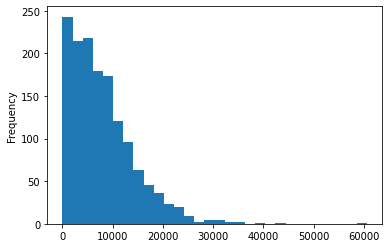

In [501]:
df_full_comparison['Diff'].plot(kind='hist', bins=30)

In [504]:
len(df_full_comparison[df_full_comparison['Diff'] > 20000]) / len(df_full_comparison)

0.05277587388622344

#### Check all record with absolute error > 20K Dolars

In [506]:
print(f"No of records having absolute error > 20K dolars is {len(df_full_comparison[df_full_comparison['Diff'] > 20000])} records")

No of records having absolute error > 20K dolars is 77 records


In [518]:
def high_correlation_to_y(corr_matrix, threshold):
    col_corr = set()  
    for idx_name in corr_matrix.index:
        if abs(np.array(corr_matrix.loc[[idx_name], ['SalePrice']])[0][0]) > threshold and idx_name != 'SalePrice': 
            col_corr.add(idx_name)
    return col_corr

high_corr_features = high_correlation_to_y(df_full_comparison.corr().round(4), 0.5)
print(f'Low correlated features: {len(set(high_corr_features))}' )

Low correlated features: 15


In [519]:
real_high_corr_feats = set(high_corr_features).intersection(set(df_full_comparison.columns))
real_high_corr_feats

{'1stFlrSF',
 'BsmtQual_Ex',
 'ExterQual_TA',
 'FullBath',
 'GarageArea',
 'GrLivArea',
 'KitchenQual_Ex',
 'KitchenQual_TA',
 'Neighborhood',
 'OverallQual',
 'Predict',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd'}

In [515]:
df_high_diff_20k = df_full_comparison[df_full_comparison['Diff'] > 20000].sort_values(by='Diff', ascending=False)
df_high_diff_20k.shape

(77, 121)

In [522]:
real_high_corr_feats = list(real_high_corr_feats) + ['SalePrice', 'Predict', 'Diff']
df_high_diff_20k[real_high_corr_feats]

,BsmtQual_Ex,ExterQual_TA,GrLivArea,OverallQual,KitchenQual_TA,KitchenQual_Ex,YearRemodAdd,GarageArea,1stFlrSF,Predict,Neighborhood,YearBuilt,TotalBsmtSF,FullBath,TotRmsAbvGrd,SalePrice,Predict,Diff
632,0,1,1411,7,1,0,1977,544.0,1411,143097.284942,13,1977,1386.0,2,6,82500,143097.284942,60597.284942
688,0,0,1419,8,0,0,2007,567.0,1419,348520.706701,22,2007,1419.0,2,7,392000,348520.706701,43479.293299
13,0,0,1494,7,0,0,2007,840.0,1494,239578.227286,16,2006,1494.0,2,7,279500,239578.227286,39921.772714
970,0,1,1192,4,1,0,1950,0.0,720,98889.502310,10,1949,720.0,1,6,135000,98889.502310,36110.497690
462,0,1,864,5,1,0,1965,360.0,864,98174.451324,6,1965,864.0,1,5,62383,98174.451324,35791.451324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,0,1,1425,6,1,0,1964,576.0,1425,160342.835532,10,1964,1425.0,2,7,180500,160342.835532,20157.164468
409,1,0,2078,8,0,1,2008,836.0,1050,319656.320523,19,2007,1034.0,2,8,339750,319656.320523,20093.679477
66,0,1,2207,7,1,0,1989,576.0,2207,200047.174432,10,1970,1947.0,2,7,180000,200047.174432,20047.174432
1450,0,0,1578,8,0,1,2009,840.0,1578,267046.893641,19,2008,1573.0,2,7,287090,267046.893641,20043.106359


In [361]:
important_features = ['1stFlrSF',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'MasVnrArea',
 'OverallQual',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'YearBuilt',
 'YearRemodAdd']

#### Check outliers for important features AGAIN

#### SalePrice

<AxesSubplot:ylabel='Density'>

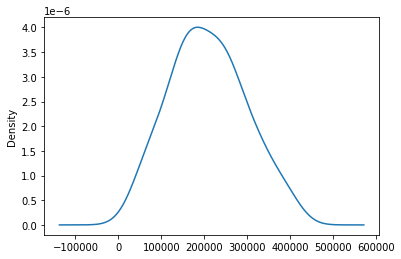

In [524]:
df_high_diff_20k['SalePrice'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

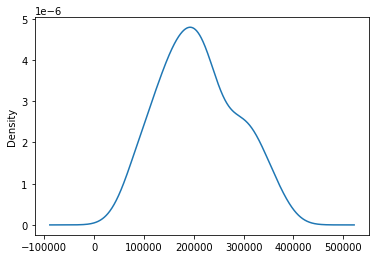

In [527]:
df_high_diff_20k['Predict'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

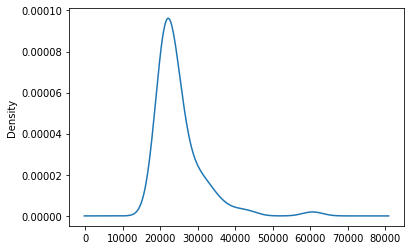

In [528]:
df_high_diff_20k['Diff'].plot(kind='kde')

**OverallQual**

<AxesSubplot:ylabel='Frequency'>

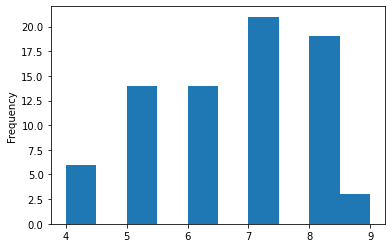

In [529]:
df_high_diff_20k['OverallQual'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

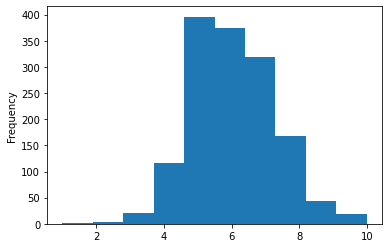

In [530]:
df_full_comparison['OverallQual'].plot(kind='hist', bins=10)

**The model might not learn enough from features**

We need to change Encoding of Quality features

In [599]:
X_train_3 = X_train_imputed.copy()
X_train_3.shape

(1459, 78)

In [600]:
y_train_3 = y_train.copy()
y_train_3.shape

(1459,)

In [601]:
X_test_3 = X_test_imputed.copy()
X_test_3.shape

(1459, 78)

##### Ordered Encoding for Quality features

In [602]:
def encode_by_ordered(serie, ordered_values, start=1):
    ''' ordered_values is ordered from small to large '''
    ord_dict = {}
    for num, label in enumerate(ordered_values, start):
        ord_dict[label] = num
    return np.array(serie.replace(ord_dict)), ord_dict, serie.name
        

In [603]:
ordered_enc_features = [
    'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'FireplaceQu',
    'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence'
]

In [604]:
ord_enc_mapping = []

In [605]:
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['LotShape'], np.array(X_train_imputed['LotShape'].value_counts(ascending=True).index), start=1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['LandContour'], np.array(X_train_imputed['LandContour'].value_counts(ascending=True).index), start=1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['LandSlope'], np.array(X_train_imputed['LandSlope'].value_counts(ascending=True).index), start=1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['ExterQual'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], start=-1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['ExterCond'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], start=-1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['BsmtQual'], ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['BsmtCond'], ['NA','Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['BsmtExposure'], ['NA','No', 'Mn', 'Av', 'Gd'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['BsmtFinType1'], ['NA','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['BsmtFinType2'], ['NA','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['HeatingQC'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['Electrical'], ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['KitchenQual'], ['Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['FireplaceQu'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['GarageFinish'], ['NA', 'Unf', 'RFn', 'Fin'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['GarageQual'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['GarageCond'], ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['PavedDrive'], ['N', 'P', 'Y'], start=1))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['PoolQC'], ['NA', 'Fa', 'TA', 'Gd', 'Ex'], start=0))
ord_enc_mapping.append(encode_by_ordered(X_train_imputed['Fence'], ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], start=0))

In [606]:
len(set(X_train_imputed.columns))

78

In [607]:
ignored_cols.append('Utilities')

In [608]:
print(f"There are {len(ordered_enc_features)} features will be encoded by ordering including Utilities")

There are 21 features will be encoded by ordering including Utilities


In [609]:
onh_enc_features =  set(categorical_cols) - set(ordered_enc_features) #MSSubClass is fake numerical col
onh_enc_features.add('MSSubClass')
print(f"There are {len(onh_enc_features)} features will be encoded by one-hot including MSSubClass")

There are 22 features will be encoded by one-hot including MSSubClass


In [610]:
numeric_features = set(X_train_imputed.columns) - set(ordered_enc_features) - set(onh_enc_features)
print(f"There are {len(numeric_features)} features is numerical features")

There are 35 features is numerical features


In [611]:
def transform_ordenc(df_features, ord_enc_mapping):
    for _, mapping, feat_name in ord_enc_mapping:
        df_features[feat_name].replace(mapping, inplace=True)
        #print(_, mapping, feat_name)
    return df_features

In [612]:
print(f"The shape of X_train_1 before encoding {X_train_3.shape}")

The shape of X_train_1 before encoding (1459, 78)


In [613]:
X_train_3 = transform_ordenc(X_train_3, ord_enc_mapping)
print(f"The shape of X_train_1 after Ordered Encoding {X_train_3.shape}")

The shape of X_train_1 after Ordered Encoding (1459, 78)


In [614]:
X_test_3 = transform_ordenc(X_test_3, ord_enc_mapping)
print(f"The shape of X_test_1 after Ordered Encoding {X_test_3.shape}")

The shape of X_test_1 after Ordered Encoding (1459, 78)


In [615]:
ignored_cols_1 = ['MiscFeature',
                 'MiscVal',
                 '3SsnPorch',
                 'Utilities',
                'MSSubClass'
                 ] + list(low_corr_features)
ignored_cols_1

['MiscFeature',
 'MiscVal',
 '3SsnPorch',
 'Utilities',
 'MSSubClass',
 '3SsnPorch',
 'MiscVal',
 'BsmtFinSF2',
 'LowQualFinSF',
 'YrSold',
 'BsmtHalfBath']

In [616]:
#remove ignored_cols
X_train_3 = remove_ignored_cols_from_features(X_train_3, ignored_cols_1)
X_test_3 = remove_ignored_cols_from_features(X_test_3, ignored_cols_1)

X_train_3.shape, X_test_3.shape

((1459, 70), (1459, 70))

##### One-hot encoding

In [617]:
# X_train_1['MSSubClass'] = X_train_1['MSSubClass'].astype('O')

In [618]:
onh_enc_features = onh_enc_features.difference(set(ignored_cols_1)).intersection(set(X_train_3.columns))
onh_enc_features

{'Alley',
 'BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Exterior1st',
 'Exterior2nd',
 'Foundation',
 'Functional',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LotConfig',
 'MSZoning',
 'MasVnrType',
 'Neighborhood',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street'}

In [619]:
onh_encoder = OneHotEncoder(
    top_categories=10,
    variables=list(onh_enc_features),
    drop_last=True)
onh_encoder.fit(X_train_3)


OneHotEncoder(drop_last=True, top_categories=10,
              variables=['CentralAir', 'HouseStyle', 'RoofMatl', 'GarageType',
                         'Functional', 'MSZoning', 'Alley', 'Condition2',
                         'Heating', 'LotConfig', 'Condition1', 'SaleType',
                         'SaleCondition', 'Foundation', 'Exterior2nd',
                         'Exterior1st', 'MasVnrType', 'Street', 'BldgType',
                         'Neighborhood', 'RoofStyle'])

In [620]:
X_train_3[onh_enc_features]

C:\Users\M S I\AppData\Local\Temp\ipykernel_12932\3611539149.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train_3[onh_enc_features]


,CentralAir,HouseStyle,RoofMatl,GarageType,Functional,MSZoning,Alley,Condition2,Heating,LotConfig,...,SaleType,SaleCondition,Foundation,Exterior2nd,Exterior1st,MasVnrType,Street,BldgType,Neighborhood,RoofStyle
0,Y,2Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,Inside,...,WD,Normal,PConc,VinylSd,VinylSd,BrkFace,Pave,1Fam,CollgCr,Gable
1,Y,1Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,FR2,...,WD,Normal,CBlock,MetalSd,MetalSd,None,Pave,1Fam,Veenker,Gable
2,Y,2Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,Inside,...,WD,Normal,PConc,VinylSd,VinylSd,BrkFace,Pave,1Fam,CollgCr,Gable
3,Y,2Story,CompShg,Detchd,Typ,RL,NA,Norm,GasA,Corner,...,WD,Abnorml,BrkTil,Wd Shng,Wd Sdng,None,Pave,1Fam,Crawfor,Gable
4,Y,2Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,FR2,...,WD,Normal,PConc,VinylSd,VinylSd,BrkFace,Pave,1Fam,NoRidge,Gable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,Y,2Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,Inside,...,WD,Normal,PConc,VinylSd,VinylSd,None,Pave,1Fam,Gilbert,Gable
1455,Y,1Story,CompShg,Attchd,Min1,RL,NA,Norm,GasA,Inside,...,WD,Normal,CBlock,Plywood,Plywood,Stone,Pave,1Fam,NWAmes,Gable
1456,Y,2Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,Inside,...,WD,Normal,Stone,CmentBd,CemntBd,None,Pave,1Fam,Crawfor,Gable
1457,Y,1Story,CompShg,Attchd,Typ,RL,NA,Norm,GasA,Inside,...,WD,Normal,CBlock,MetalSd,MetalSd,None,Pave,1Fam,NAmes,Hip


In [ ]:
X_train_3 = onh_encoder.transform(X_train_3)

In [622]:
print(f"The shape of X_train_3 after One-hot Encoding {X_train_3.shape}")

The shape of X_train_3 after One-hot Encoding (1459, 185)


In [ ]:
X_test_3 = onh_encoder.transform(X_test_3)

In [624]:
print(f"The shape of X_test_1 after One-hot Encoding {X_test_3.shape}")

The shape of X_test_1 after One-hot Encoding (1459, 185)


In [625]:
print(f"The shape of X_train_1 after REMOVING ignored_cols {X_train_3.shape}")
print(f"The shape of X_test_1 after REMOVING ignored_cols {X_test_3.shape}")

The shape of X_train_1 after REMOVING ignored_cols (1459, 185)
The shape of X_test_1 after REMOVING ignored_cols (1459, 185)


##### Train bgr_model on X_train_3

In [626]:
model_3 = create_best_gbr_model(GBR_best_params, X_train_3, y_train_3)
score = rmse_cv(model_3, X_train_3, y_train_3)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1199 (0.0197)



- The CV score = 0.1199
- The test score (on Kaggle) = 0.12969

The features X_train_3 DOES NOT IMPROVE the model

#### From X_train_1, Adding more features

In [642]:
def add_features(X_train):
    X_train['YrBltAndRemod']=X_train['YearBuilt']+X_train['YearRemodAdd']
    X_train['TotalSF']=X_train['TotalBsmtSF'] + X_train['1stFlrSF'] + X_train['2ndFlrSF']

    X_train['Total_sqr_footage'] = (X_train['BsmtFinSF1'] + X_train['BsmtFinSF2'] +
                                     X_train['1stFlrSF'] + X_train['2ndFlrSF'])

    X_train['Total_Bathrooms'] = (X_train['FullBath'] + (0.5 * X_train['HalfBath']) +
                                   X_train['BsmtFullBath'] + (0.5 * X_train['BsmtHalfBath']))

    X_train['Total_porch_sf'] = (X_train['OpenPorchSF']  +
                                  X_train['EnclosedPorch'] + X_train['ScreenPorch'] +
                                  X_train['WoodDeckSF'])
    
    X_train['TotalSF_OvrQual'] = X_train_1['OverallQual'] * X_train['TotalSF']
    
    X_train['TotalSF_CondQual'] = X_train_1['OverallCond'] * X_train['TotalSF']
    
    
    return X_train

In [643]:
X_train_1_1 = X_train_1.copy()

print(f"The shape of X_train_1_1 before adding features {X_train_1_1.shape}")
X_train_1_1 = add_features(X_train_1_1)
print(f"The shape of X_train_1_1 after adding features {X_train_1_1.shape}")

The shape of X_train_1_1 before adding features (1459, 118)
The shape of X_train_1_1 after adding features (1459, 125)


In [644]:
X_test_1_1 = X_test_1.copy()

print(f"The shape of X_test_1_1 before adding features {X_test_1_1.shape}")
X_test_1_1 = add_features(X_test_1_1)
print(f"The shape of X_test_1_1 after adding features {X_test_1_1.shape}")

The shape of X_test_1_1 before adding features (1459, 118)
The shape of X_test_1_1 after adding features (1459, 125)


In [646]:
y_train_1_1 = y_train_1.copy()

model_1_1 = create_best_gbr_model(GBR_best_params, X_train_1_1, y_train_1_1)
score = rmse_cv(model_1_1, X_train_1_1, y_train_1_1)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1180 (0.0172)



- The CV score = 0.1180
- The test score (on Kaggle) = 0.18465

The features X_train_1_1 make the model too overfitting

### The best model

- The CV score = 0.1192
- The test score (on Kaggle) = 0.12459
- Ranking 584/3944 at 15:50 Oct 10 2022

[House Prices Leaderboard](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard#)

![house-price-leaderboard](house-prices-leaderboard.png "House Prices Leaderboard")

In [655]:
model_1

GradientBoostingRegressor(learning_rate=0.007742636826811269, max_depth=4,
                          n_estimators=1500, random_state=42, subsample=0.5)

In [657]:
X_train_1.shape

(1459, 118)

### Create submission

In [647]:
make_submission(model_1, X_test_1, X_test_id, 'gbr_model_X_train_1.csv')

### Save the best model

In [659]:
from joblib import dump, load
dump(model_1, 'best_gbr_model.joblib') 

['best_gbr_model.joblib']

In [660]:
best_gbr_model = load('best_gbr_model.joblib') 

In [661]:
score = rmse_cv(best_gbr_model, X_train_1, y_train_1)
print("Averaged score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Averaged score: 0.1192 (0.0172)



In [667]:
y_train_pred_1 = best_gbr_model.predict(X_train_1)

rmse = np.sqrt(np.sum(np.square(np.array(y_train_1) - np.array(y_train_pred_1))) / len(y_train_1)) 
rmse

10184.537217860543

In [ ]:
model = ElasticNet(alpha = 1e+1, l1_ratio = 0.01, tol = 0.001, random_state=0)
exec_model_selection(model, X_train_sets, y_train)